<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Librairies-du-projet" data-toc-modified-id="Librairies-du-projet-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Librairies du projet</a></span></li><li><span><a href="#Lecture-de-l'échantillon-initial" data-toc-modified-id="Lecture-de-l'échantillon-initial-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Lecture de l'échantillon initial</a></span></li><li><span><a href="#Les-valeurs-manquantes" data-toc-modified-id="Les-valeurs-manquantes-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Les valeurs manquantes</a></span></li><li><span><a href="#Separation-des-données-pour-l'apprentissage" data-toc-modified-id="Separation-des-données-pour-l'apprentissage-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Separation des données pour l'apprentissage</a></span></li><li><span><a href="#Déclaration-des-classifieurs" data-toc-modified-id="Déclaration-des-classifieurs-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Déclaration des classifieurs</a></span></li><li><span><a href="#Choix-des-classifieurs" data-toc-modified-id="Choix-des-classifieurs-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Choix des classifieurs</a></span><ul class="toc-item"><li><span><a href="#Résultats-d'une-première-exécution" data-toc-modified-id="Résultats-d'une-première-exécution-6.1"><span class="toc-item-num">6.1&nbsp;&nbsp;</span>Résultats d'une première exécution</a></span></li><li><span><a href="#Etude-de-la-classification-avec-les-arbres-de-décision" data-toc-modified-id="Etude-de-la-classification-avec-les-arbres-de-décision-6.2"><span class="toc-item-num">6.2&nbsp;&nbsp;</span>Etude de la classification avec les arbres de décision</a></span></li></ul></li><li><span><a href="#Traitement-centrage-et-réduction" data-toc-modified-id="Traitement-centrage-et-réduction-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Traitement centrage et réduction</a></span></li><li><span><a href="#Transformation-des-modalités-des-variables-qualitatives-en-colonnes" data-toc-modified-id="Transformation-des-modalités-des-variables-qualitatives-en-colonnes-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Transformation des modalités des variables qualitatives en colonnes</a></span></li></ul></div>

In [1]:
import numpy as np, pandas as pd, seaborn as sns  
import os, warnings, time
from matplotlib import pyplot as plt

# %pylab inline
%matplotlib inline
if int(str(sns.__version__).split('.')[1]) > 8 : 
    plt.style.use('seaborn-v0_8-darkgrid')
else:
    plt.style.use('seaborn-darkgrid')
    
sns.set(font_scale=2)
warnings.filterwarnings(action="ignore")
seed = 123456789

# Librairies du projet

In [2]:
from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import NuSVC, SVC, OneClassSVM
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import ConstantKernel, RBF, RationalQuadratic, ExpSineSquared, DotProduct, Matern, WhiteKernel

from sklearn.tree import DecisionTreeClassifier, export_graphviz, plot_tree
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB, ComplementNB
from sklearn.metrics import roc_curve, auc

from sklearn.metrics  import make_scorer, confusion_matrix, roc_curve, auc, accuracy_score, log_loss, hamming_loss, \
                             precision_score, recall_score, f1_score, jaccard_score,  \
                             precision_recall_curve, average_precision_score
from sklearn.preprocessing import LabelEncoder

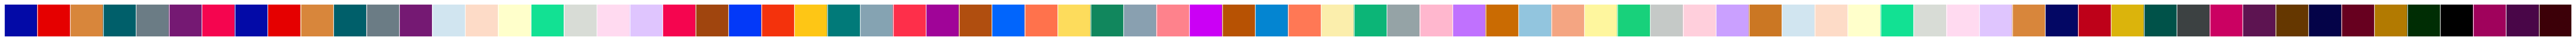

In [3]:
palette = [ "#030aa7", "#e50000", "#d8863b", "#005f6a", "#6b7c85", "#751973",
            "#f5054f", 
            "#030aa7", "#e50000", "#d8863b", "#005f6a", "#6b7c85", "#751973", "#d1e5f0", "#fddbc7",
            "#ffffcb", "#12e193", "#d8dcd6", "#ffdaf0", "#dfc5fe", "#f5054f", "#a0450e",
            "#0339f8", "#f4320c", "#fec615", "#017a79", "#85a3b2", "#fe2f4a", "#a00498", "#b04e0f",
            "#0165fc", "#ff724c", "#fddc5c", "#11875d", "#89a0b0", "#fe828c", "#cb00f5", "#b75203",
            "#0485d1", "#ff7855", "#fbeeac", "#0cb577", "#95a3a6", "#ffb7ce", "#c071fe", "#ca6b02",
            "#92c5de", "#f4a582", "#fef69e", "#18d17b", "#c5c9c7", "#ffcfdc", "#caa0ff", "#cb7723",
            "#d1e5f0", "#fddbc7", "#ffffcb", "#12e193", "#d8dcd6", "#ffdaf0", "#dfc5fe", "#d8863b",
            "#030764", "#be0119", "#dbb40c", "#005249", "#3c4142", "#cb0162", "#5d1451", "#653700",
            "#040348", "#67001f", "#b27a01", "#002d04", "#000000", "#a0025c", "#490648", "#3c0008"
          ]
sns.palplot(sns.color_palette(palette))

In [4]:
from datetime import datetime as dt

repertoireRacine  = '.'
nomProjet         = 'Classification de la maladie rénale chronique'

repertoireProjet  = os.path.join(repertoireRacine, nomProjet)
repertoireDonnees = os.path.join(repertoireProjet, 'repertoire.donnees')
repertoireImages  = os.path.join(repertoireProjet, 'repertoire.images')


def controleExistenceRepertoire( repertoire, create_if_needed=True):
    """Voir si le répertoire existe. S'il n'existe pas il est créé."""
    path_exists = os.path.exists(repertoire)
    if path_exists:
        if not os.path.isdir(repertoire):
            raise Exception("Trouvé le nom  "+repertoire +" mais c'est un fichier, pas un répertoire")
            # return False
        return True
    if create_if_needed:
        os.makedirs(repertoire)

def sauvegarderImage( fichier):
    """Enregistrez la figure. Appelez la méthode juste avant plt.show ()."""
    controleExistenceRepertoire(repertoireImages)
    plt.savefig(os.path.join(repertoireImages,
                             fichier+f"--{dt.now().strftime('%Y_%m_%d_%H.%M.%S')}.png"), 
                             dpi=600, 
                             bbox_inches='tight')

def sauvegarderImageSNS( sns_plot, fichier):
    """Enregistrez la figure. Appelez la méthode juste avant plt.show ()."""
    controleExistenceRepertoire(repertoireImages)
    fig = sns_plot.get_figure()
    fig.savefig(os.path.join(repertoireImages,fichier+'.png'))
    
controleExistenceRepertoire(repertoireProjet);
controleExistenceRepertoire(repertoireDonnees);
controleExistenceRepertoire(repertoireImages);

def afficheDistribution(colonne, cible):
        plt.figure(figsize=(14,12))
        sns.distplot(colonne[
                           cible == 1],
                       color="steelblue")
        sns.distplot(colonne[
                           cible == 0],
                       color="red")
        plt.axline((colonne.median(), 0), (colonne.median(), 1), linewidth=1, color='r', linestyle='--')
        sauvegarderImage("La distribution des colonnes")    
        plt.show()
        
def createColumnsQualitatives(donnees,col):
    valeurs = donnees[col].sort_values().unique()
    for i in valeurs : 
        nom = col+'_'+str(i)
        donnees[nom] = donnees[col].apply(lambda x : 1 if x==i else 0)
    donnees.drop(labels=col, axis=1, inplace=True)        

# Lecture de l'échantillon initial


<img src="https://raw.githubusercontent.com/rbizoi/IntelligenceEnDonneesDeSante/main/images/EchantillonInitial.png" width="800">

>> **Vous trouvez les données et leur description :**<br>
>> https://archive.ics.uci.edu/ml/datasets/chronic_kidney_disease<br>
>> https://www.kaggle.com/datasets/abhia1999/chronic-kidney-disease<br>


>> **age** - age                    <br>
>> **bp** - blood pressure          <br>
>> **sg** - specific gravity        <br>
>> **al** - albumin                 <br>
>> **su** - sugar                   <br>
>> **rbc** - red blood cells        <br>
>> **pc** - pus cell                <br>
>> **pcc** - pus cell clumps        <br>
>> **ba** - bacteria                <br>
>> **bgr** - blood glucose random   <br>
>> **bu** - blood urea              <br>
>> **sc** - serum creatinine        <br>
>> **sod** - sodium                 <br>
>> **pot** - potassium              <br>
>> **hemo** - hemoglobin            <br>
>> **pcv** - packed cell volume     <br>
>> **wc** - white blood cell count  <br>
>> **rc** - red blood cell count    <br>
>> **htn** - hypertension           <br>
>> **dm** - diabetes mellitus       <br>
>> **cad** - coronary artery disease<br>
>> **appet** - appetite             <br>
>> **pe** - pedal edema             <br>
>> **ane** - anemia                 <br>
>> **class** - class                <br>

In [5]:
donnees = pd.read_csv('../donnees/Chronic kidney disease/new_model.csv')
variablesQualitatives = ['Al','Su','Rbc', 'Htn']
donnees[variablesQualitatives] = donnees[variablesQualitatives].astype('int16')
variablesQuantitatives  = donnees.drop(columns=['Class']+variablesQualitatives).columns
cible = 'Class'
donnees.head()

,Bp,Sg,Al,Su,Rbc,Bu,Sc,Sod,Pot,Hemo,Wbcc,Rbcc,Htn,Class
0,80.0,1.020,1,0,1,36.0,1.2,137.53,4.63,15.4,7800.0,5.20,1,1
1,50.0,1.020,4,0,1,18.0,0.8,137.53,4.63,11.3,6000.0,4.71,0,1
2,80.0,1.010,2,3,1,53.0,1.8,137.53,4.63,9.6,7500.0,4.71,0,1
3,70.0,1.005,4,0,1,56.0,3.8,111.00,2.50,11.2,6700.0,3.90,1,1
4,80.0,1.010,2,0,1,26.0,1.4,137.53,4.63,11.6,7300.0,4.60,0,1


In [6]:
donnees.describe()

,Bp,Sg,Al,Su,Rbc,Bu,Sc,Sod,Pot,Hemo,Wbcc,Rbcc,Htn,Class
count,400.000000,400.000000,400.000000,400.000000,400.000000,400.00000,400.00000,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000
mean,76.455000,1.017712,1.015000,0.395000,0.882500,57.40550,3.07235,137.529025,4.627850,12.526900,8406.090000,4.708275,0.367500,0.625000
std,13.476536,0.005434,1.272329,1.040038,0.322418,49.28597,5.61749,9.204273,2.819783,2.716171,2523.219976,0.840315,0.482728,0.484729
min,50.000000,1.005000,0.000000,0.000000,0.000000,1.50000,0.40000,4.500000,2.500000,3.100000,2200.000000,2.100000,0.000000,0.000000
25%,70.000000,1.015000,0.000000,0.000000,1.000000,27.00000,0.90000,135.000000,4.000000,10.875000,6975.000000,4.500000,0.000000,0.000000
50%,78.000000,1.020000,1.000000,0.000000,1.000000,44.00000,1.40000,137.530000,4.630000,12.530000,8406.000000,4.710000,0.000000,1.000000
75%,80.000000,1.020000,2.000000,0.000000,1.000000,61.75000,3.07000,141.000000,4.800000,14.625000,9400.000000,5.100000,1.000000,1.000000
max,180.000000,1.025000,5.000000,5.000000,1.000000,391.00000,76.00000,163.000000,47.000000,17.800000,26400.000000,8.000000,1.000000,1.000000


# Les valeurs manquantes

In [7]:
donnees.isna().sum()

Bp       0
Sg       0
Al       0
Su       0
Rbc      0
Bu       0
Sc       0
Sod      0
Pot      0
Hemo     0
Wbcc     0
Rbcc     0
Htn      0
Class    0
dtype: int64

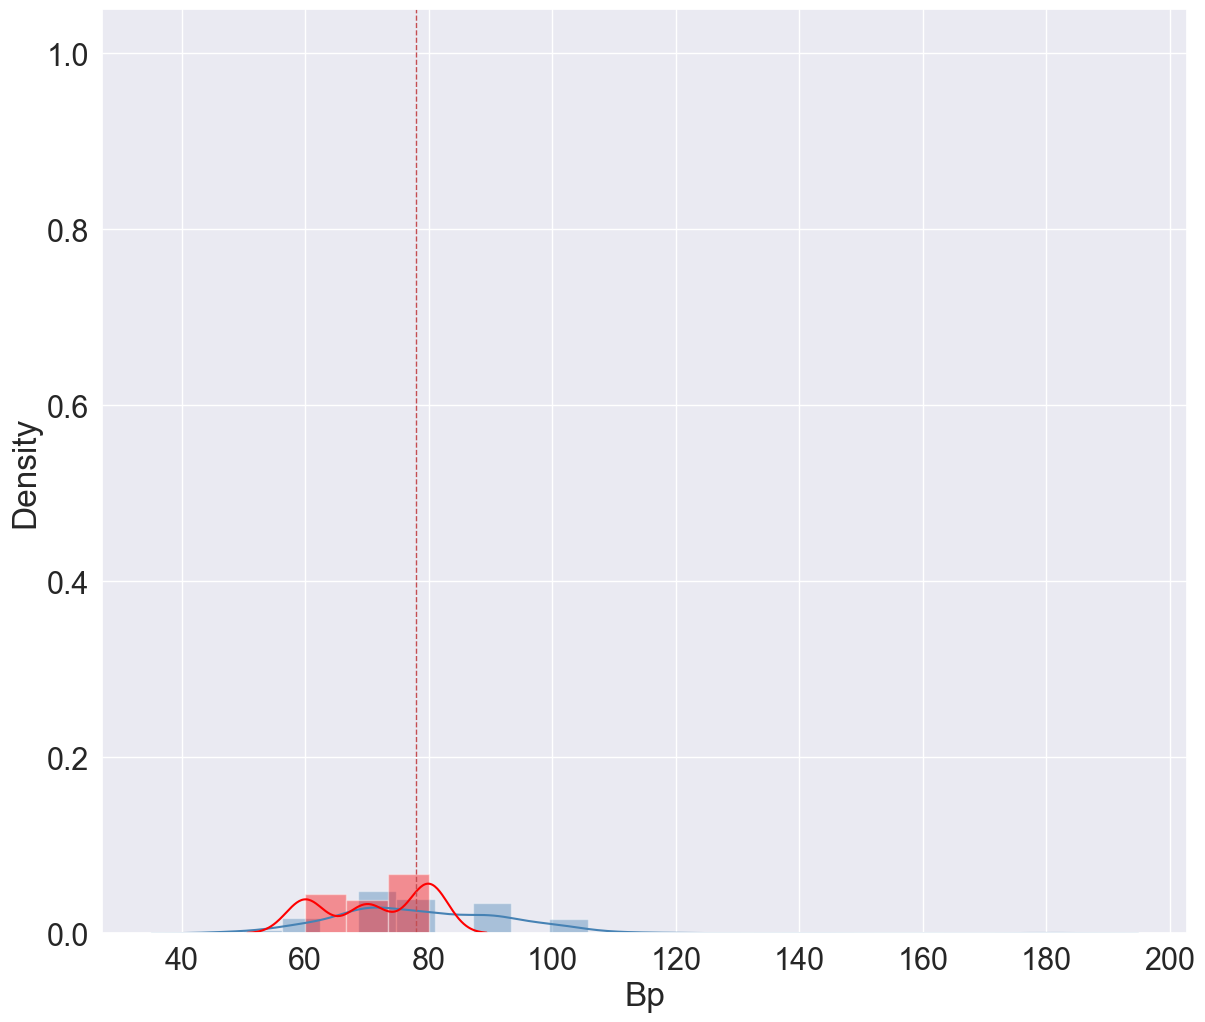

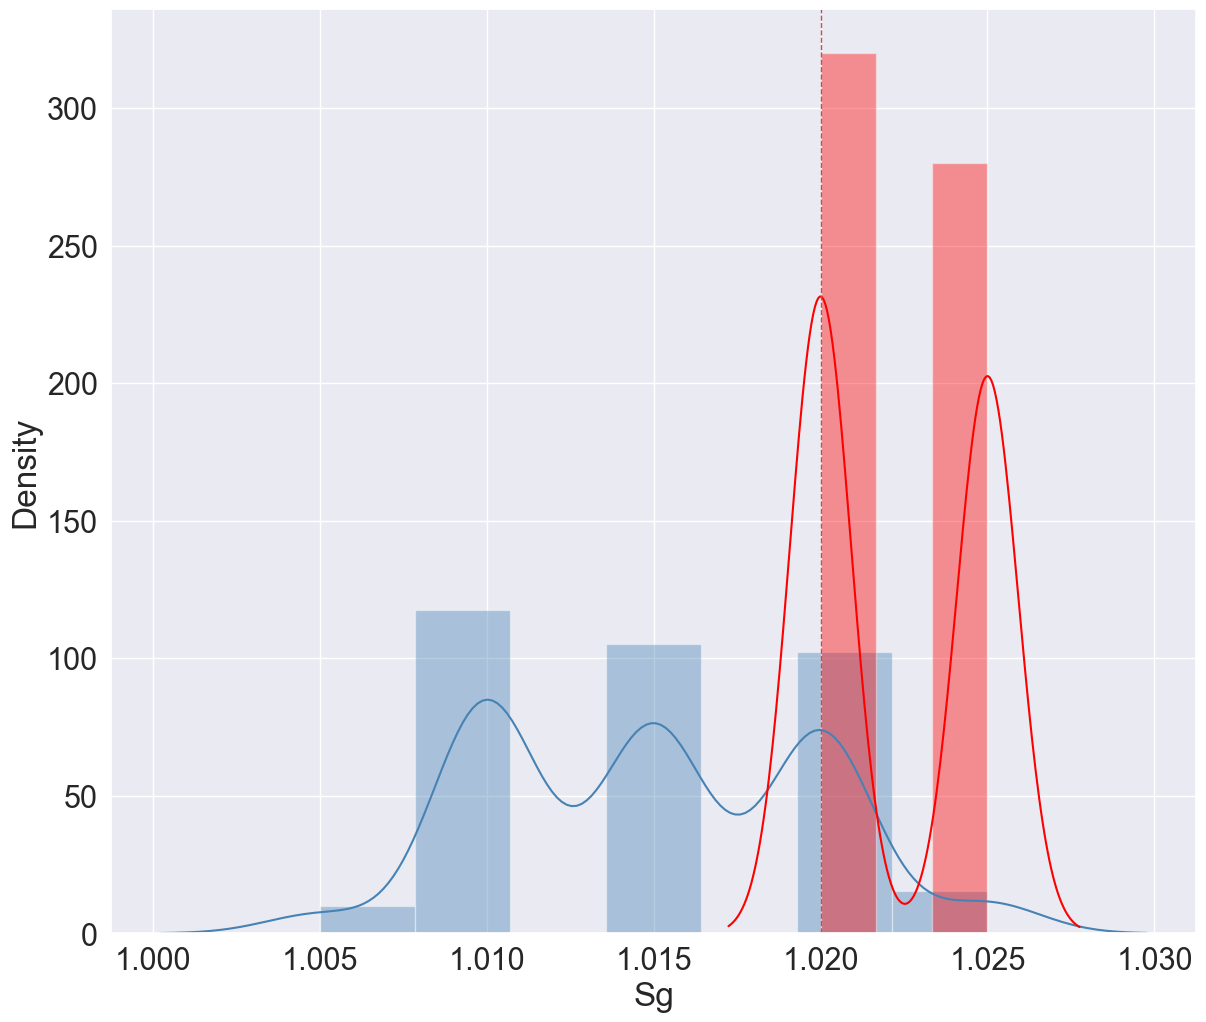

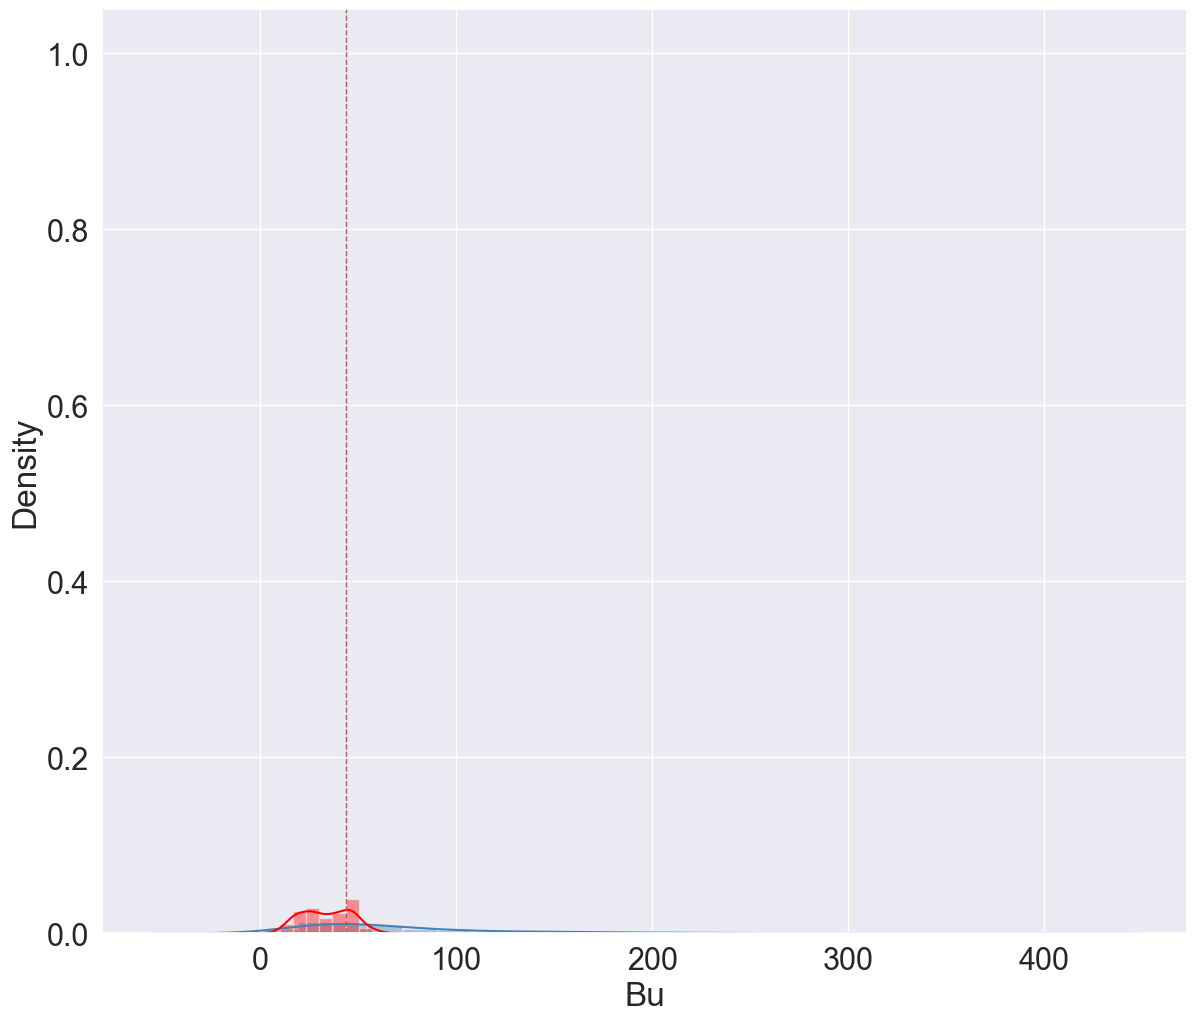

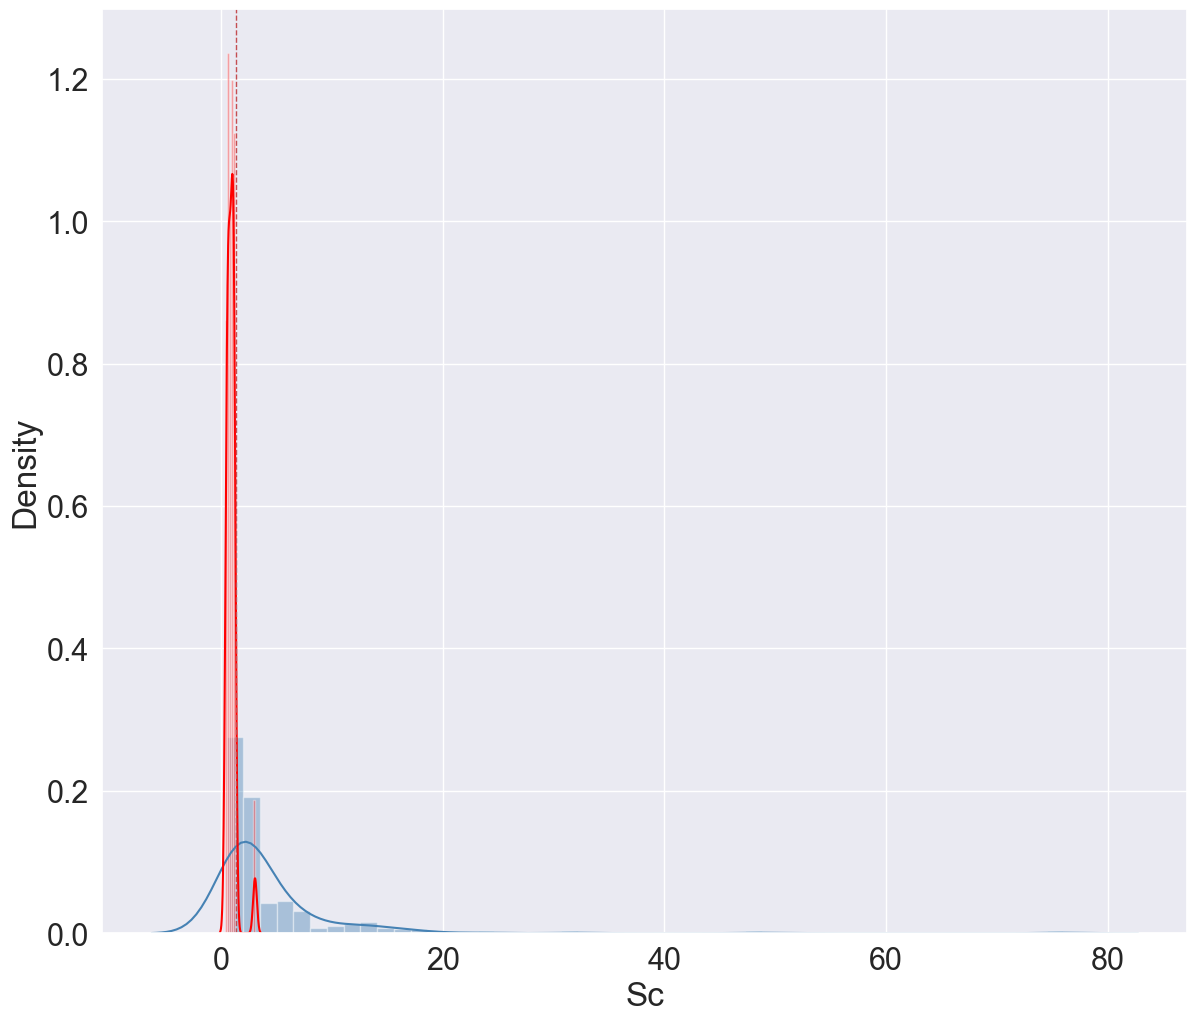

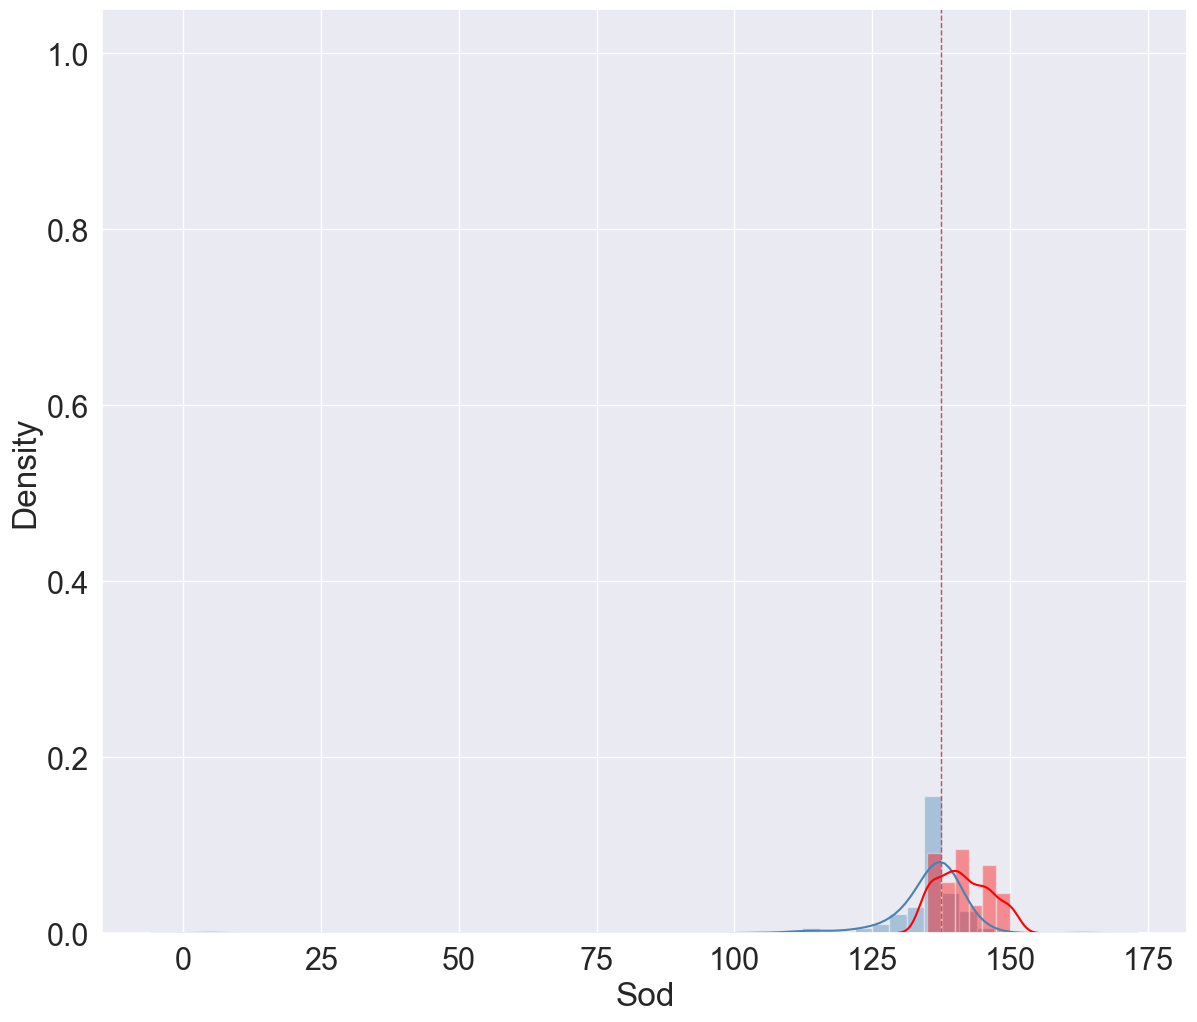

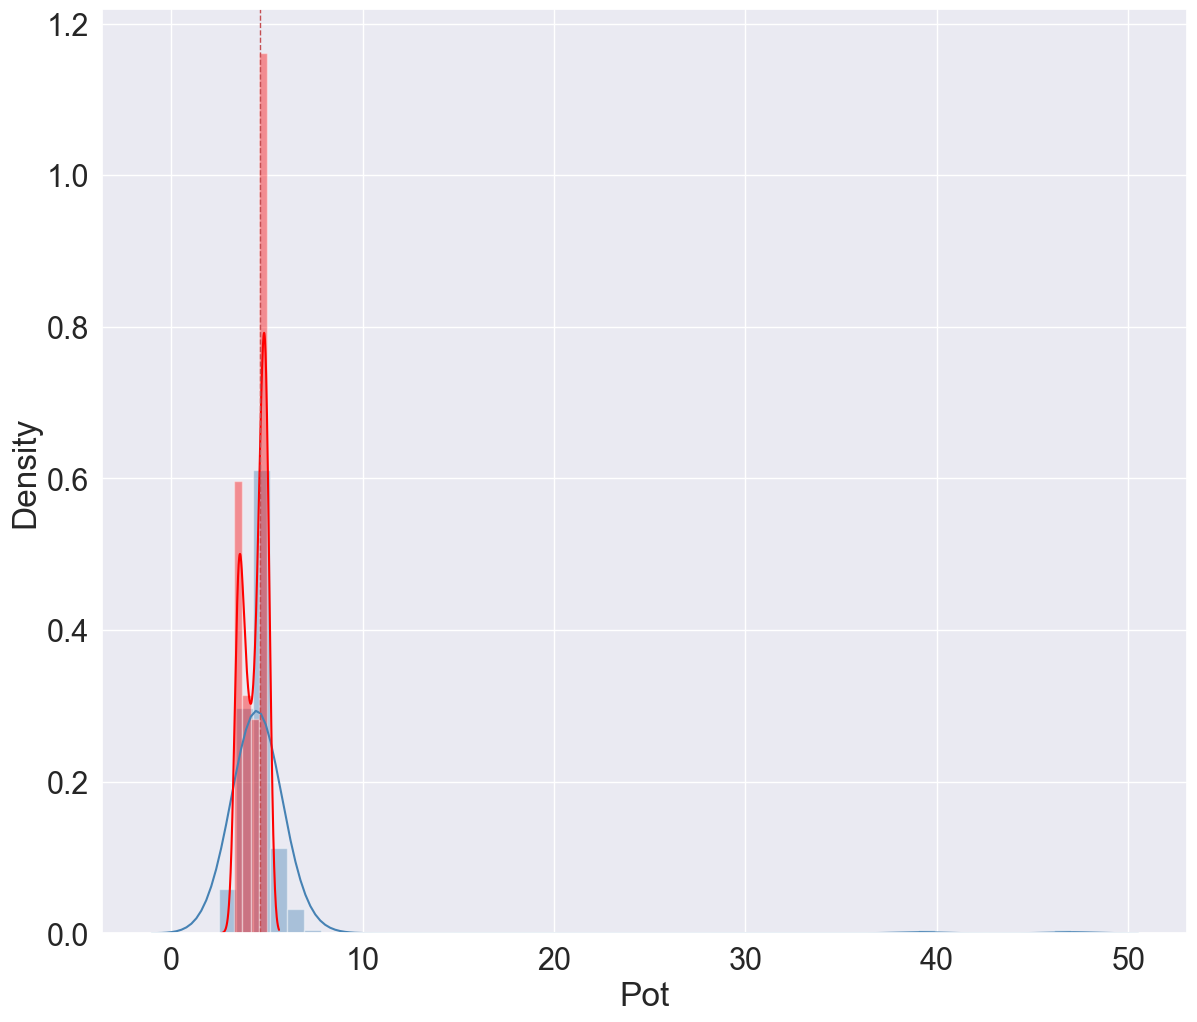

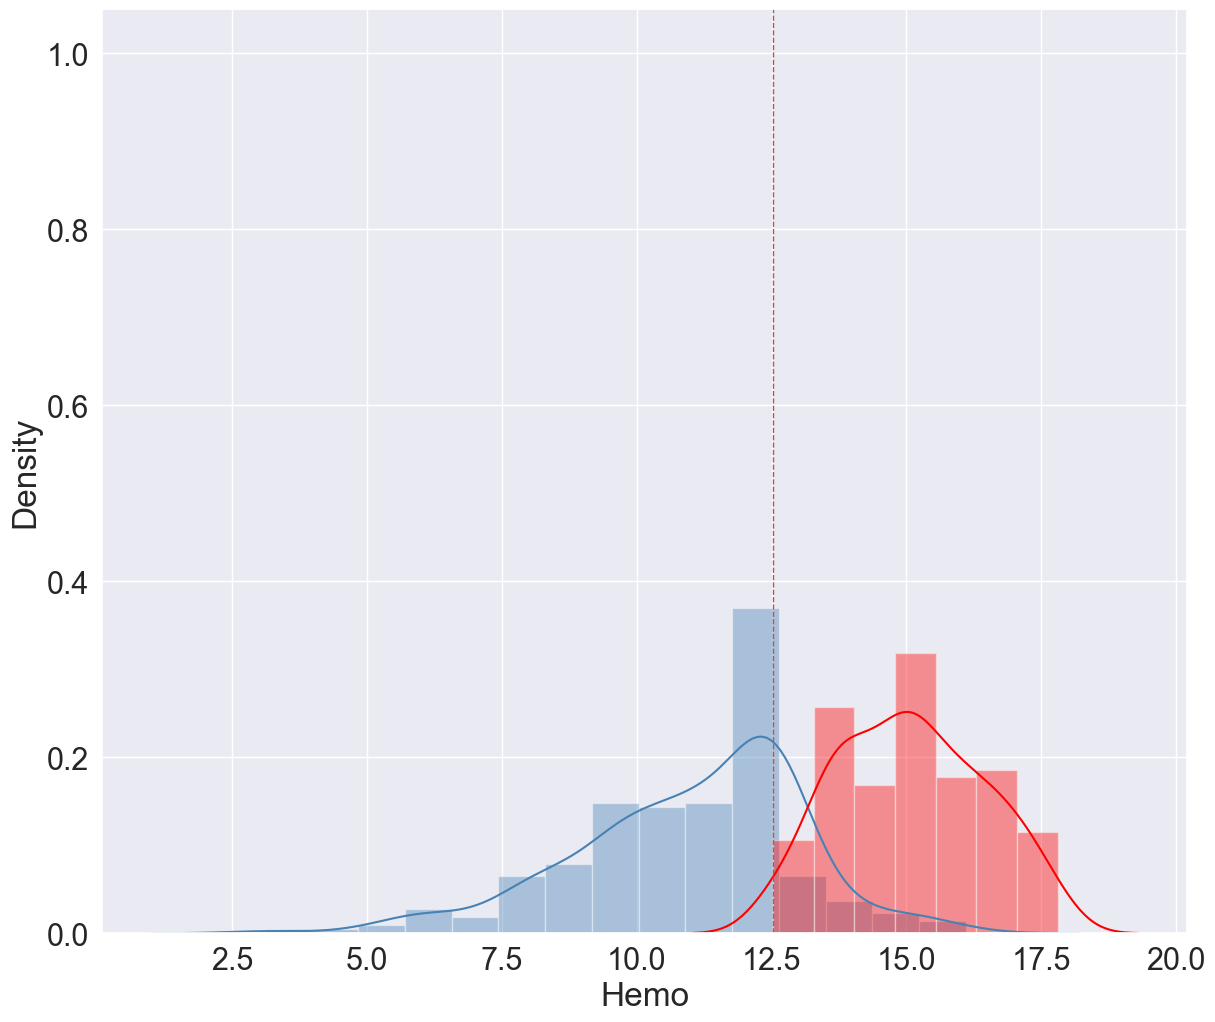

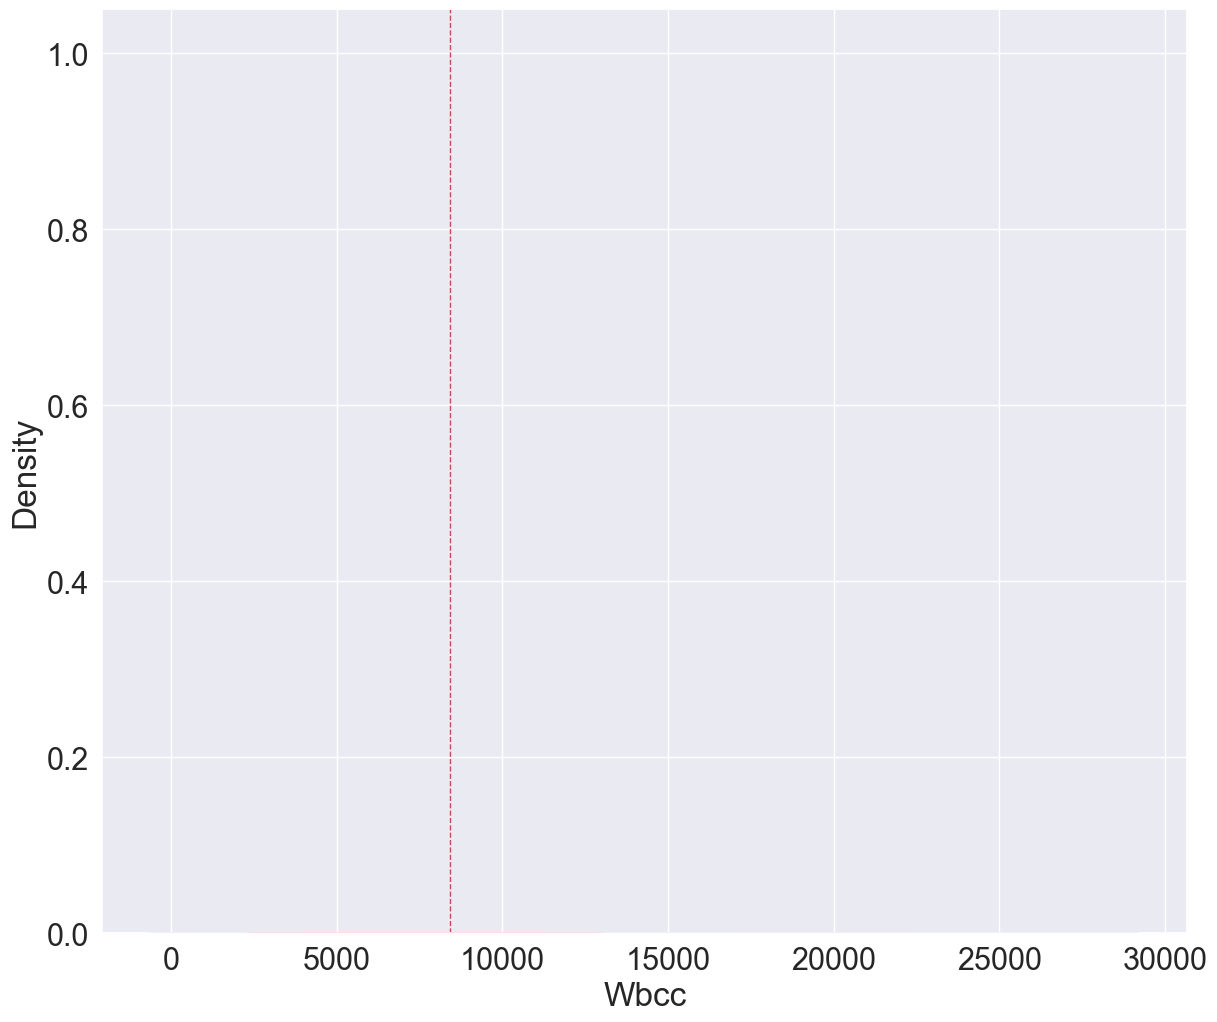

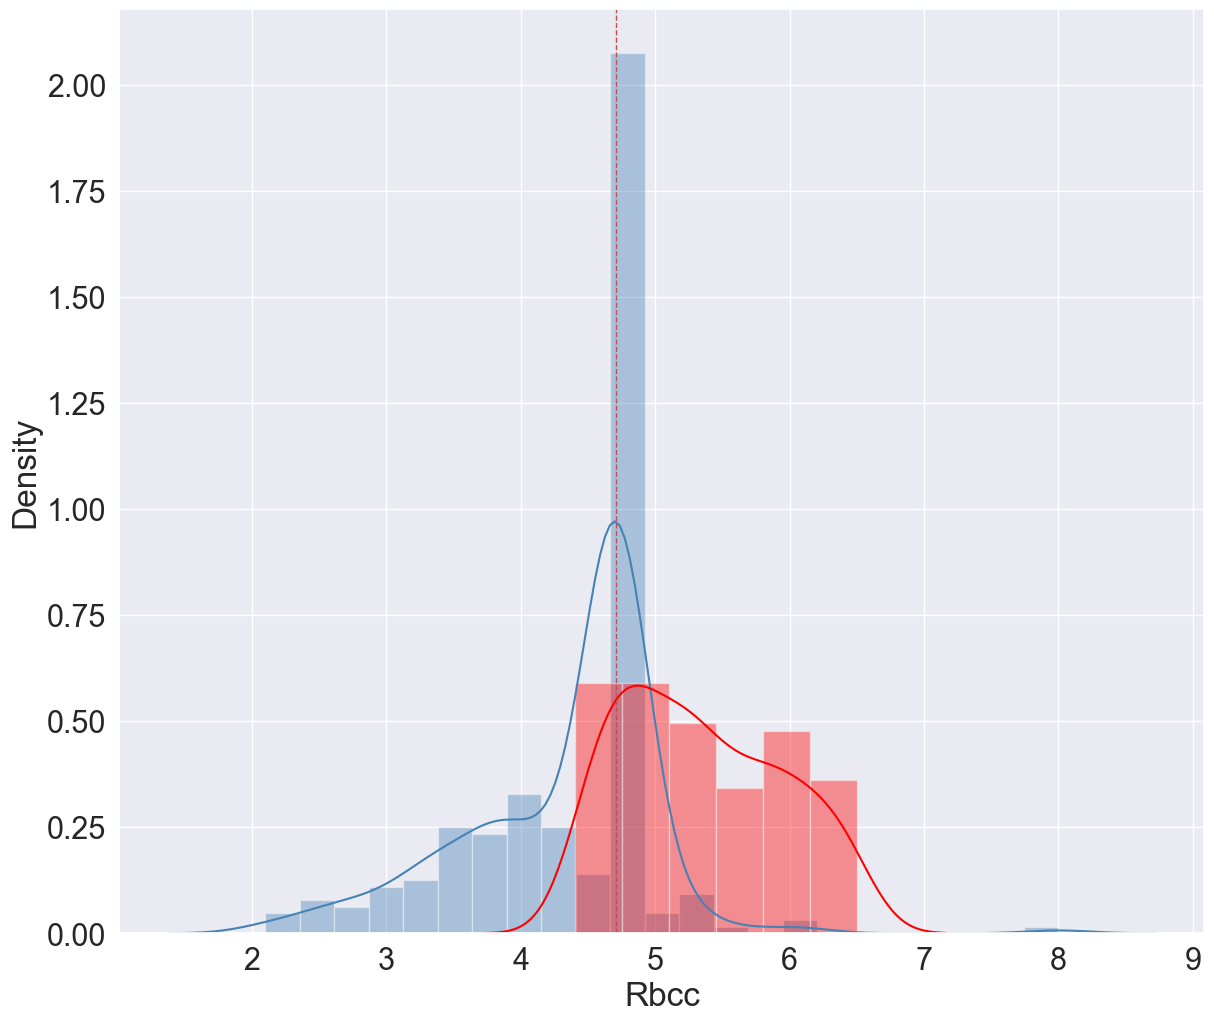

In [8]:
for colonne in variablesQuantitatives:
    afficheDistribution(donnees[colonne], donnees.Class)

In [9]:
donnees_sauvegarde = donnees.copy()

In [10]:
X = donnees.drop(columns='Class')
y = donnees.Class

# Separation des données pour l'apprentissage

<img src="https://raw.githubusercontent.com/rbizoi/IntelligenceEnDonneesDeSante/main/images/EchantillonApprentissageTest.png" width="800">

In [11]:
X_train, X_test, y_train, y_test = train_test_split( X, 
                                                     y, 
                                                     test_size=0.2, 
                                                     random_state=seed, 
                                                     stratify = y
                                                   ) 

In [12]:
X_train.shape, X_test.shape

((320, 13), (80, 13))

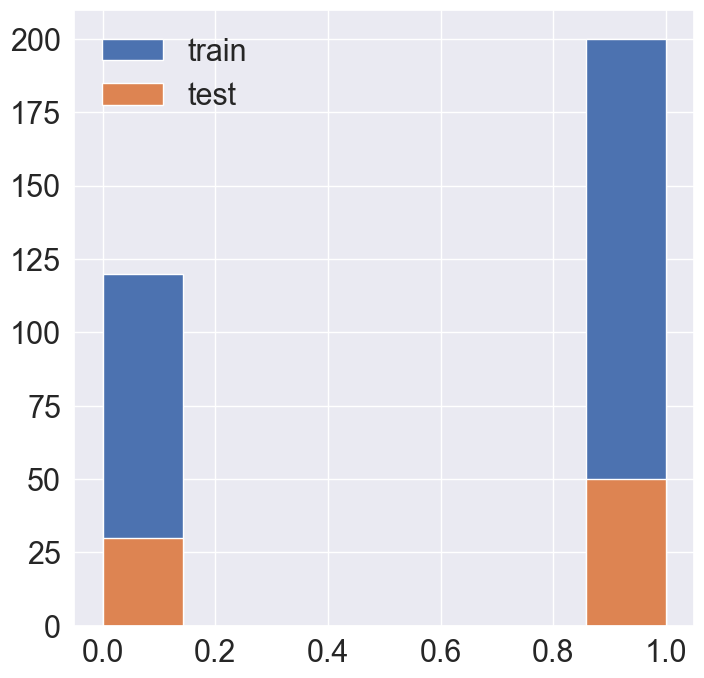

In [13]:
y_train.hist(bins=7, figsize=(8,8), label='train');
y_test.hist(bins=7, figsize=(8,8), label='test');
plt.legend();
sauvegarderImage("La separation des données pour l'apprentissage")

# Déclaration des classifieurs 

In [14]:
names = [
            'Decision Tree', 
            'Random_Forest',
            'AdaBoost',
            'LogisticRegression',
            # 'Stochastic_GD',
            'Gaussian_Process',
            'Nearest_Neighbors',
            'Linear_SVMC', 
            'NonLinaire_SVMC',
            'GaussianNaiveBayes',
            'QuadraticDiscriminant',
            'Neural_Net'
        ]

classifiers = [
            DecisionTreeClassifier(max_depth=3),
            RandomForestClassifier(
                max_depth=2,
                max_features=3,
                min_samples_split=4,
                n_estimators=25,
                n_jobs=-1
            ),
            AdaBoostClassifier(n_estimators=25),    
            LogisticRegression(
                C=0.81113,
                max_iter=800,
                penalty='l2',
                solver='lbfgs',
                n_jobs=-1
            ),
            # SGDClassifier(loss='log', alpha=0.01, max_iter=200, fit_intercept=True),
            GaussianProcessClassifier(
                n_jobs=-1
            ),
            KNeighborsClassifier(
                algorithm='ball_tree',
                n_neighbors=17,
                p=1,
                weights='distance',
                n_jobs=-1
            ),
            SVC(
                kernel="linear" , 
                C=0.025, 
                probability=True),
            NuSVC(
                kernel="rbf",
                gamma=0.5,
                nu=0.195,
                probability=True,
            ),
            GaussianNB(),
            QuadraticDiscriminantAnalysis(),
            MLPClassifier(alpha=1),
        ]

dictModels = {name:clf for name, clf in zip(names, classifiers)}

# dictModels.pop('Decision Tree')
# dictModels.pop('Gaussian_Process')
# dictModels.pop('Stochastic_GD')
# dictModels.pop('NonLinaire_SVMC')
dictModels.pop('QuadraticDiscriminant')
dictModels.pop('Neural_Net')

MLPClassifier(alpha=1)

In [15]:
dictModels

{'Decision Tree': DecisionTreeClassifier(max_depth=3),
 'Random_Forest': RandomForestClassifier(max_depth=2, max_features=3, min_samples_split=4,
                        n_estimators=25, n_jobs=-1),
 'AdaBoost': AdaBoostClassifier(n_estimators=25),
 'LogisticRegression': LogisticRegression(C=0.81113, max_iter=800, n_jobs=-1),
 'Gaussian_Process': GaussianProcessClassifier(n_jobs=-1),
 'Nearest_Neighbors': KNeighborsClassifier(algorithm='ball_tree', n_jobs=-1, n_neighbors=17, p=1,
                      weights='distance'),
 'Linear_SVMC': SVC(C=0.025, kernel='linear', probability=True),
 'NonLinaire_SVMC': NuSVC(gamma=0.5, nu=0.195, probability=True),
 'GaussianNaiveBayes': GaussianNB()}

# Choix des classifieurs 

In [16]:
def executeChoixDesClassifieurs(dictModels, X_train, y_train, X_test, y_test, figsize=(18,36), lw = 1, seed = seed):
    np.random.seed(seed)
    t0 = time.time()  

    plt.figure(figsize=figsize)
    if int(str(sns.__version__).split('.')[1]) > 8 : 
        plt.style.use('seaborn-v0_8-darkgrid')
    else:
        plt.style.use('seaborn-darkgrid')
    couleurs = sns.hls_palette(len(dictModels.keys()), l=.4, s=.9)
    r_acc,r_aucROC = dict(),dict()
    fauxPositifs, vraisPositifs, probabilites = dict(),dict(),dict()
    accuracy,logloss,hammingloss,precision,sensibilite,f1,jaccard = dict(),dict(),dict(),dict(),dict(),dict(),dict()
    prec, rec, tauxPR, avgPrecRec =  dict(),dict(),dict(),dict()

    for i, nom in enumerate(dictModels):    
        t1 = time.time()  
        dictModels[nom].fit(X_train, y_train)

        y_probas = dictModels[nom].predict_proba(X_test)
        y_pred = dictModels[nom].predict(X_test)
        fauxPositifs[nom], vraisPositifs[nom], probabilites[nom] = roc_curve(y_test.ravel(), y_probas[:, 1])

        r_aucROC[nom]     = auc(fauxPositifs[nom], vraisPositifs[nom])
        accuracy[nom]     = accuracy_score(y_test,y_pred)
        logloss[nom]      = log_loss(y_test,y_pred)
        hammingloss[nom]  = hamming_loss(y_test,y_pred)
        precision[nom]    = precision_score(y_test,y_pred)
        sensibilite[nom]  = recall_score(y_test,y_pred)
        f1[nom]           = f1_score(y_test,y_pred)
        jaccard[nom]      = jaccard_score(y_test,y_pred)


        prec[nom], rec[nom], tauxPR[nom] = precision_recall_curve(y_test.ravel(), y_probas[:, 1])
        avgPrecRec[nom] = average_precision_score(y_test.ravel(), y_probas[:, 1])

        print(f'{nom:21s}'+(' %.4f' % accuracy[nom]).lstrip('0'),end='\t--\t')
        print ("Area under the ROC curve : %0.4f" % r_aucROC[nom],end='\t--\t')
        print('Exécution  :'+('%.2fs' % (time.time() - t1)).lstrip('0'))

        plt.subplot(2, 1, 1)
        plt.plot(fauxPositifs[nom], vraisPositifs[nom], color=couleurs[i], label=nom + '(AUC = %0.4f)' % r_aucROC[nom])

        plt.subplot(2, 1, 2)
        plt.step(rec[nom], prec[nom], where='post', color=couleurs[i], label=f"{nom}(AP = {avgPrecRec[nom]:0.8f})")#alpha=0.8, 
        plt.fill_between(rec[nom], prec[nom], step='post', alpha=0.05)



    plt.subplot(2, 1, 1)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('Le taux de faux Positifs-(1 - Spécificité) = VN / (FP + VN)',size=18)
    plt.ylabel('Le taux de vrais positifs-Sensibilité = VP / (VP + FN)',size=18)
    plt.title('La courbe ROC (Receiver Operating Caracteristic)',size=20)
    plt.legend(loc="lower right")    

    plt.subplot(2, 1, 2)
    f_scores = np.linspace(0.2, 0.9, num=7)
    for f_score in f_scores:
        x = np.linspace(0.01, 1)
        y = f_score * x / (2 * x - f_score)
        l, = plt.plot(x[y >= 0], y[y >= 0], color='gray', alpha=0.2)
        plt.annotate('f1={0:0.1f}'.format(f_score), xy=(0.9, y[45] + 0.02))

    # plt.subplot(2, 1, 2)                
    # plt.plot([0, 1], [0.5, 0.5], 'k--')
    plt.plot([0, 1], [0, 1], 'k--', lw=lw)
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('Sensibilité(Rappel) = VP / (VP + FN)', size=18)
    plt.ylabel('Précision = VP / (VP + FP)', size=18)      
    plt.title('La courbe Précision-Rappel',size=20)
    plt.legend(loc="lower left")    

    sauvegarderImage("Les courbes ROC et Précision-Rappel")    
    plt.show()

    print('Exécution  :'+('%.2fs' % (time.time() - t0)).lstrip('0'))

    resultat = pd.DataFrame(pd.Series(r_aucROC), columns=["aucROC"])
    resultat['avgPrecRec']     = pd.Series(avgPrecRec   )
    resultat['accuracy']     = pd.Series(accuracy   )
    resultat['f1']           = pd.Series(f1         )
    resultat['precision']    = pd.Series(precision  )
    resultat['sensibilite']  = pd.Series(sensibilite)
    resultat['logloss']      = pd.Series(logloss    )
    resultat['hammingloss']  = pd.Series(hammingloss)
    resultat['jaccard']      = pd.Series(jaccard    )

    resultat.sort_values('f1',ascending=False)
    
    return resultat

## Résultats d'une première exécution

Decision Tree         0.9750	--	Area under the ROC curve : 0.9973	--	Exécution  :.03s
Random_Forest         0.9875	--	Area under the ROC curve : 1.0000	--	Exécution  :.10s
AdaBoost              0.9875	--	Area under the ROC curve : 0.9993	--	Exécution  :.07s
LogisticRegression    0.9375	--	Area under the ROC curve : 0.9873	--	Exécution  :1.83s
Gaussian_Process      0.6125	--	Area under the ROC curve : 0.5993	--	Exécution  :.19s
Nearest_Neighbors     0.7375	--	Area under the ROC curve : 0.8040	--	Exécution  :.04s
Linear_SVMC           0.9500	--	Area under the ROC curve : 0.9840	--	Exécution  :11.11s
NonLinaire_SVMC       0.6250	--	Area under the ROC curve : 0.6447	--	Exécution  :.07s
GaussianNaiveBayes    0.9375	--	Area under the ROC curve : 0.9920	--	Exécution  :.01s


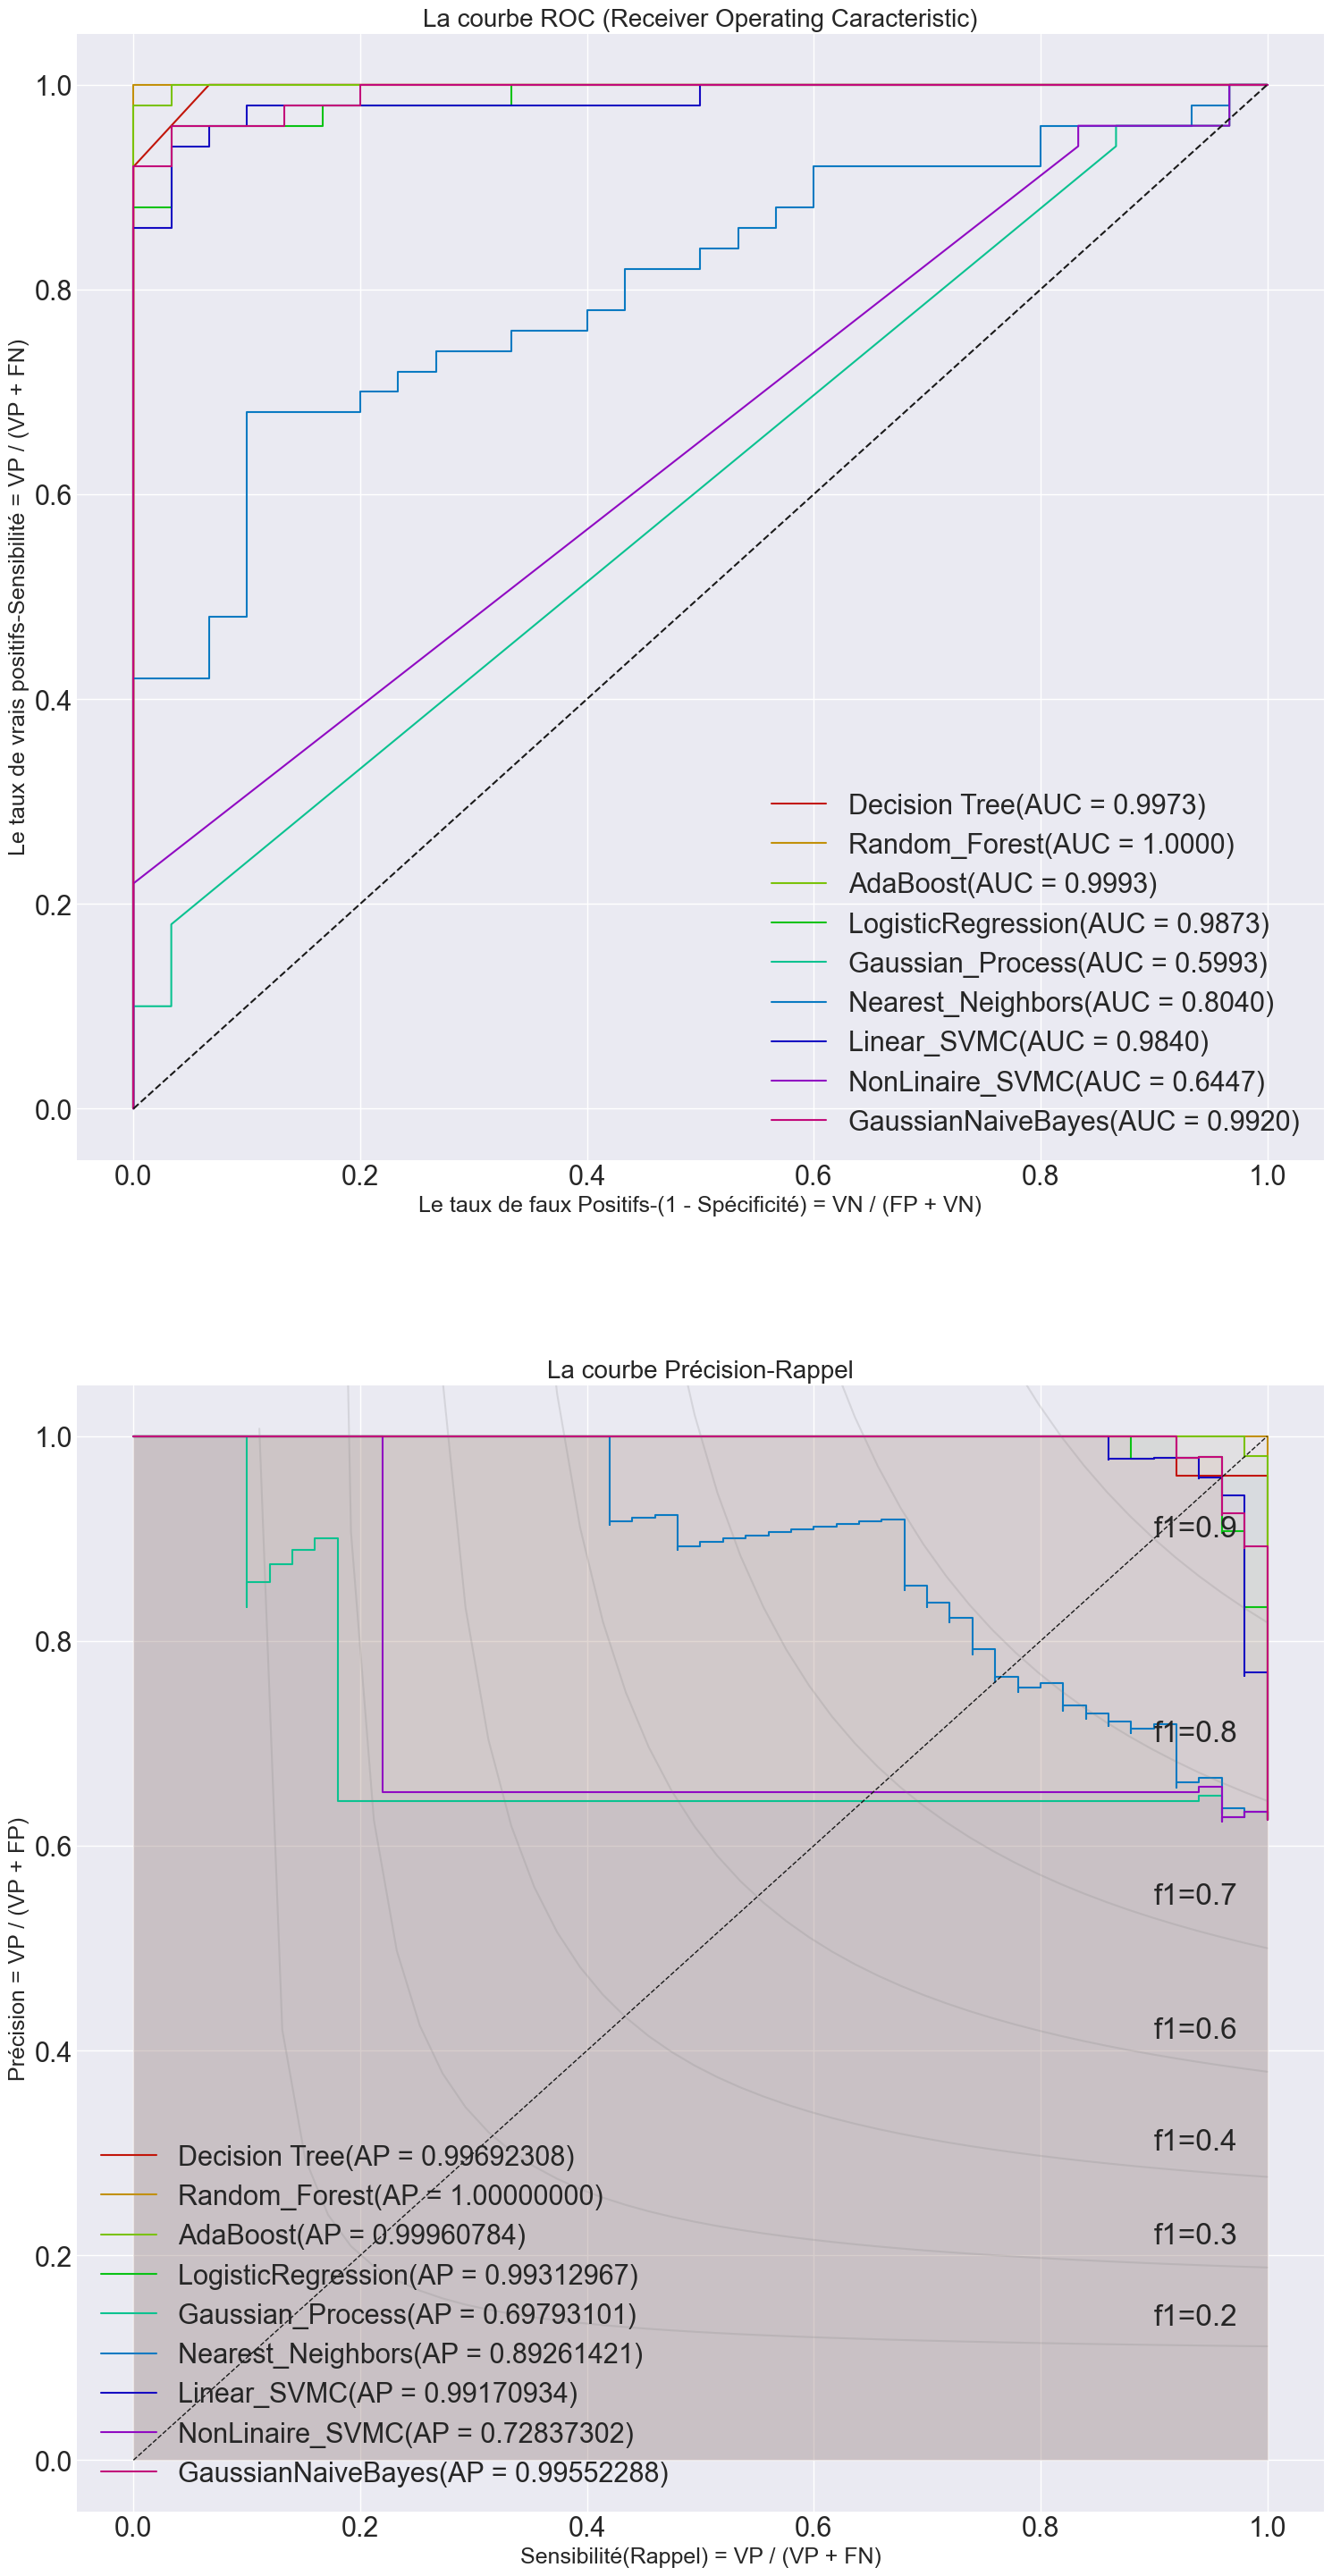

Exécution  :27.64s


In [17]:
resultats = executeChoixDesClassifieurs(dictModels, X_train, y_train, X_test, y_test, figsize=(18,36), lw = 1)

In [18]:
resultats.sort_values('f1',ascending=False)

,aucROC,avgPrecRec,accuracy,f1,precision,sensibilite,logloss,hammingloss,jaccard
Random_Forest,1.000000,1.000000,0.9875,0.990099,0.980392,1.00,0.450546,0.0125,0.980392
AdaBoost,0.999333,0.999608,0.9875,0.989899,1.000000,0.98,0.450546,0.0125,0.980000
Decision Tree,0.997333,0.996923,0.9750,0.980392,0.961538,1.00,0.901091,0.0250,0.961538
Linear_SVMC,0.984000,0.991709,0.9500,0.960000,0.960000,0.96,1.802183,0.0500,0.923077
LogisticRegression,0.987333,0.993130,0.9375,0.950495,0.941176,0.96,2.252728,0.0625,0.905660
GaussianNaiveBayes,0.992000,0.995523,0.9375,0.947368,1.000000,0.90,2.252728,0.0625,0.900000
NonLinaire_SVMC,0.644667,0.728373,0.6250,0.769231,0.625000,1.00,13.516370,0.3750,0.625000
Nearest_Neighbors,0.804000,0.892614,0.7375,0.752941,0.914286,0.64,9.461459,0.2625,0.603774
Gaussian_Process,0.599333,0.697931,0.6125,0.607595,0.827586,0.48,13.966916,0.3875,0.436364


In [19]:
resultats['nom']='initial'

In [20]:
resultats_etude = resultats

In [21]:
resultats_etude.sort_values('accuracy',ascending=False)

,aucROC,avgPrecRec,accuracy,f1,precision,sensibilite,logloss,hammingloss,jaccard,nom
Random_Forest,1.000000,1.000000,0.9875,0.990099,0.980392,1.00,0.450546,0.0125,0.980392,initial
AdaBoost,0.999333,0.999608,0.9875,0.989899,1.000000,0.98,0.450546,0.0125,0.980000,initial
Decision Tree,0.997333,0.996923,0.9750,0.980392,0.961538,1.00,0.901091,0.0250,0.961538,initial
Linear_SVMC,0.984000,0.991709,0.9500,0.960000,0.960000,0.96,1.802183,0.0500,0.923077,initial
LogisticRegression,0.987333,0.993130,0.9375,0.950495,0.941176,0.96,2.252728,0.0625,0.905660,initial
GaussianNaiveBayes,0.992000,0.995523,0.9375,0.947368,1.000000,0.90,2.252728,0.0625,0.900000,initial
Nearest_Neighbors,0.804000,0.892614,0.7375,0.752941,0.914286,0.64,9.461459,0.2625,0.603774,initial
NonLinaire_SVMC,0.644667,0.728373,0.6250,0.769231,0.625000,1.00,13.516370,0.3750,0.625000,initial
Gaussian_Process,0.599333,0.697931,0.6125,0.607595,0.827586,0.48,13.966916,0.3875,0.436364,initial


## Etude de la classification avec les arbres de décision

In [22]:
dictModels['Decision Tree']

DecisionTreeClassifier(max_depth=3)

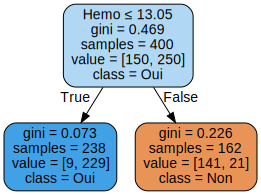

In [23]:
from sklearn.tree import DecisionTreeClassifier,export_graphviz
classifieur = DecisionTreeClassifier(max_depth=1)
classifieur.fit(X,y)
import graphviz 
dot_data = export_graphviz(classifieur, 
                out_file=None, 
                feature_names=X.columns,  
                class_names=['Non','Oui'],  
                filled=True, 
                rounded=True,  
                special_characters=True) 
graph = graphviz.Source(dot_data,
                        filename='ArbreDecissionKidneyDisease01', 
                        directory=repertoireImages,
                        format='png')
graph.render()
graph

In [24]:
(141+229)*100/400, (9+21)*100/400

(92.5, 7.5)

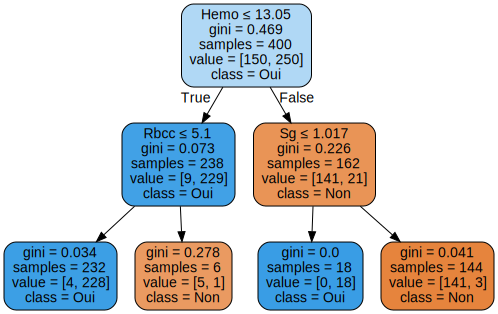

In [25]:
from sklearn.tree import DecisionTreeClassifier,export_graphviz
classifieur = DecisionTreeClassifier(max_depth=2)
classifieur.fit(X,y)
import graphviz 
dot_data = export_graphviz(classifieur, 
                out_file=None, 
                feature_names=X.columns,  
                class_names=['Non','Oui'],  
                filled=True, 
                rounded=True,  
                special_characters=True) 
graph = graphviz.Source(dot_data,
                        filename='ArbreDecissionKidneyDisease02', 
                        directory=repertoireImages,
                        format='png')
# graph = graphviz.Source(dot_data)
graph.render()
graph

In [26]:
(4+1+3)*100/400, (228+5+18+141)*100/400

(2.0, 98.0)

In [27]:
repertoireImages

'.\\Classification de la maladie rénale chronique\\repertoire.images'

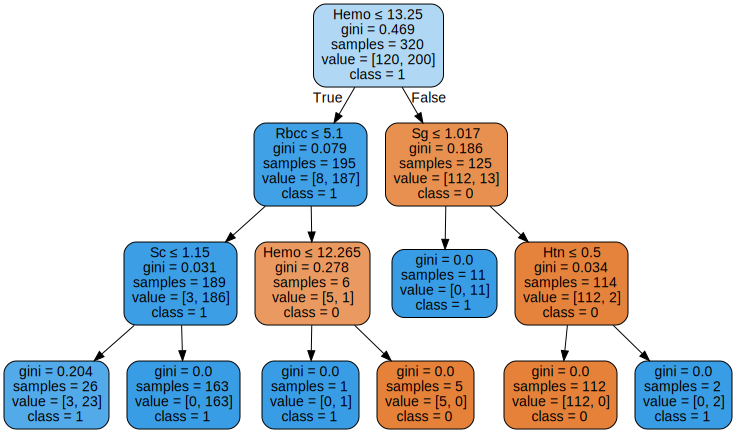

In [29]:
from sklearn.tree import DecisionTreeClassifier,export_graphviz
import graphviz 
dot_data = export_graphviz(dictModels['Decision Tree'], 
                out_file=None, 
                feature_names=X.columns,  
                class_names=np.sort(y.unique()).astype('str'),  
                filled=True, 
                rounded=True,  
                special_characters=True) 
graph = graphviz.Source(dot_data,
                        filename='ArbreDecissionKidneyDisease03', 
                        directory=repertoireImages,
                        format='png')
graph.render()
graph

In [30]:
(3)*100/320, (23+163+1+5+112+2+11)*100/320,(3+23+163+1+5+112+2+11)

(0.9375, 99.0625, 320)

# Traitement centrage et réduction

In [31]:
donnees = donnees_sauvegarde.copy()

In [32]:
from sklearn.preprocessing import StandardScaler,MinMaxScaler
modelStd = StandardScaler()
modelStd.fit(donnees[variablesQuantitatives])
donnees[variablesQuantitatives] = modelStd.transform(donnees[variablesQuantitatives])

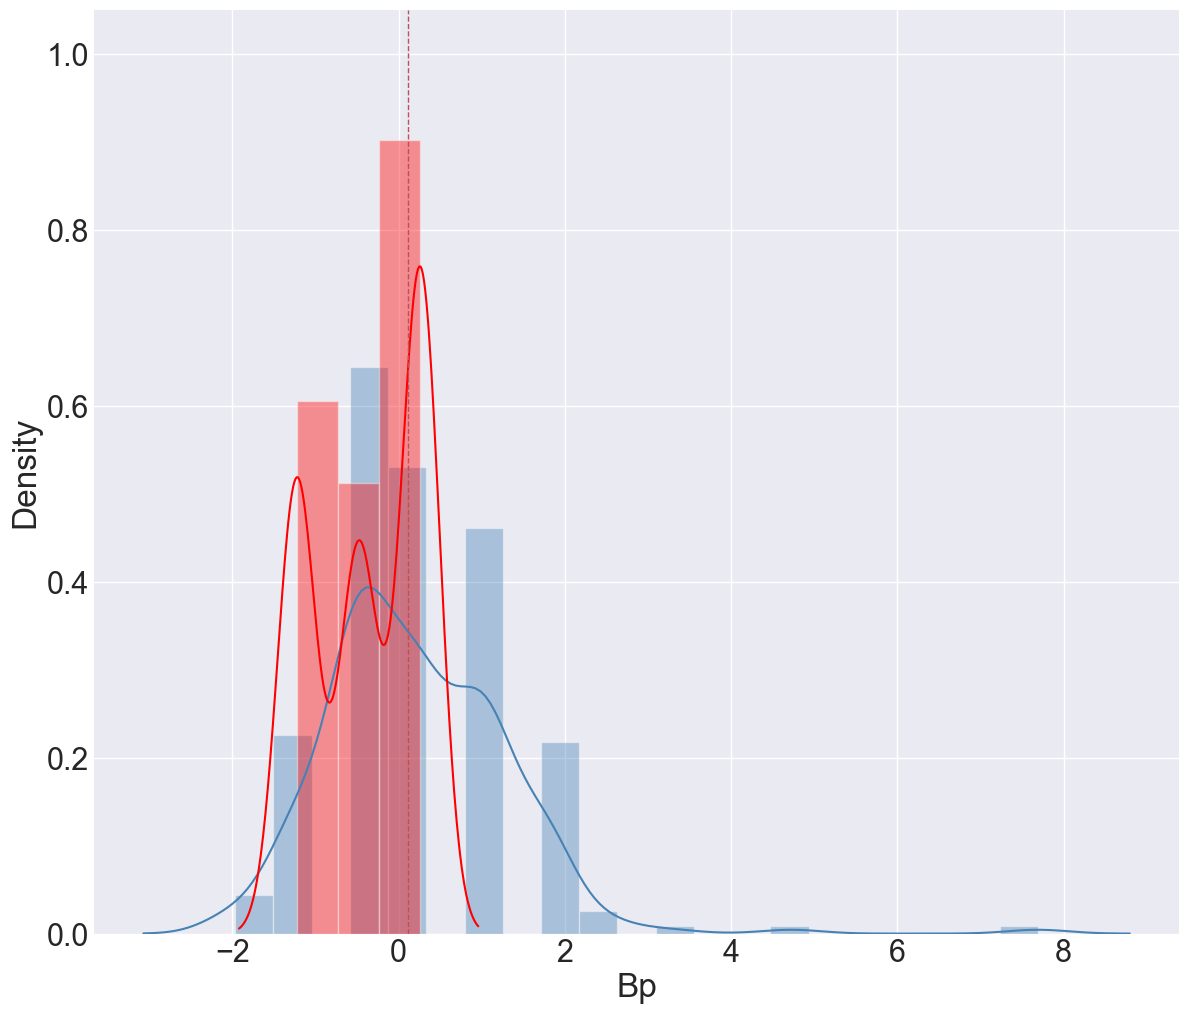

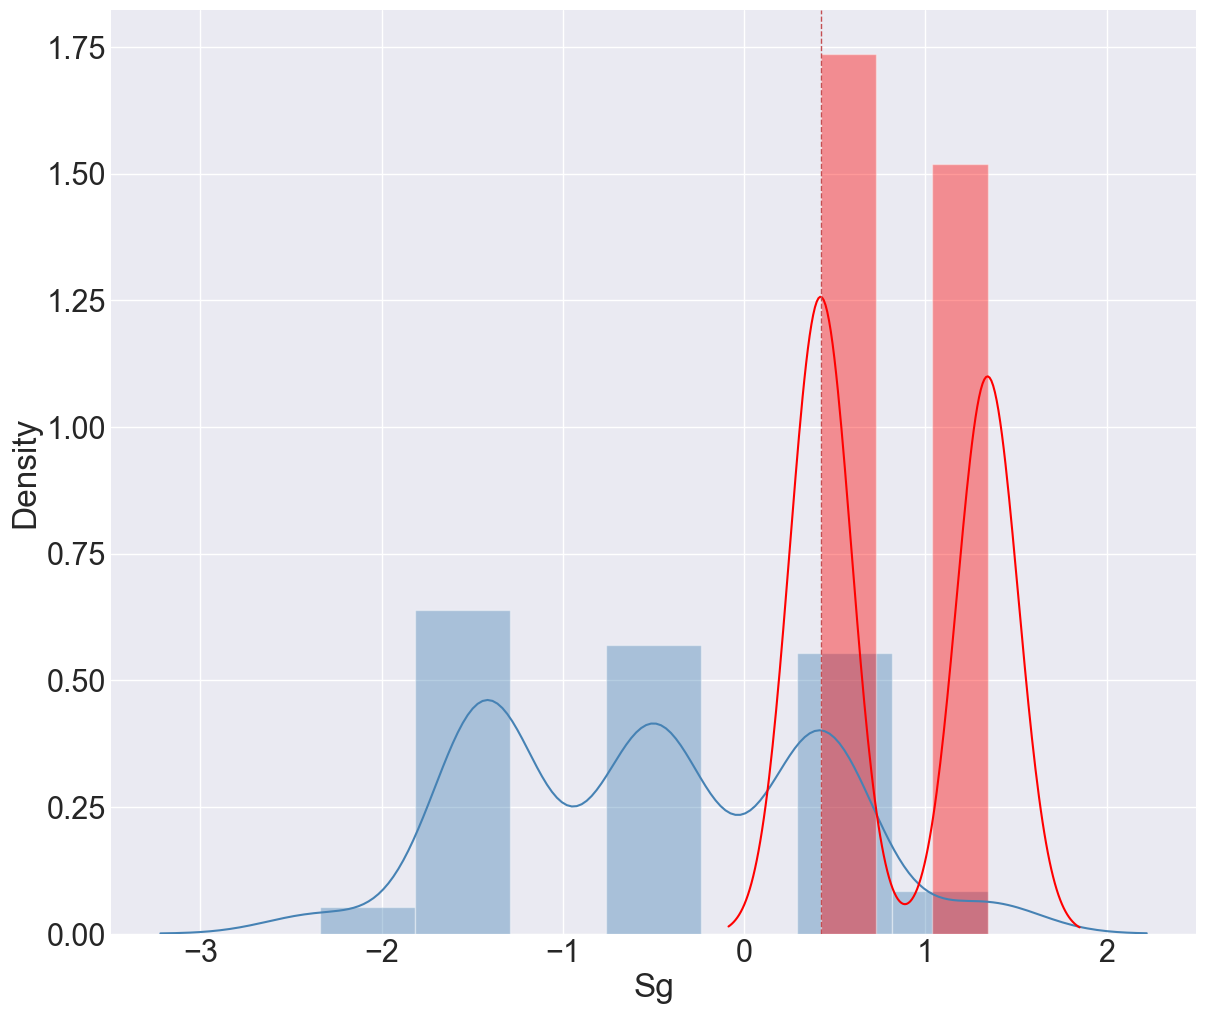

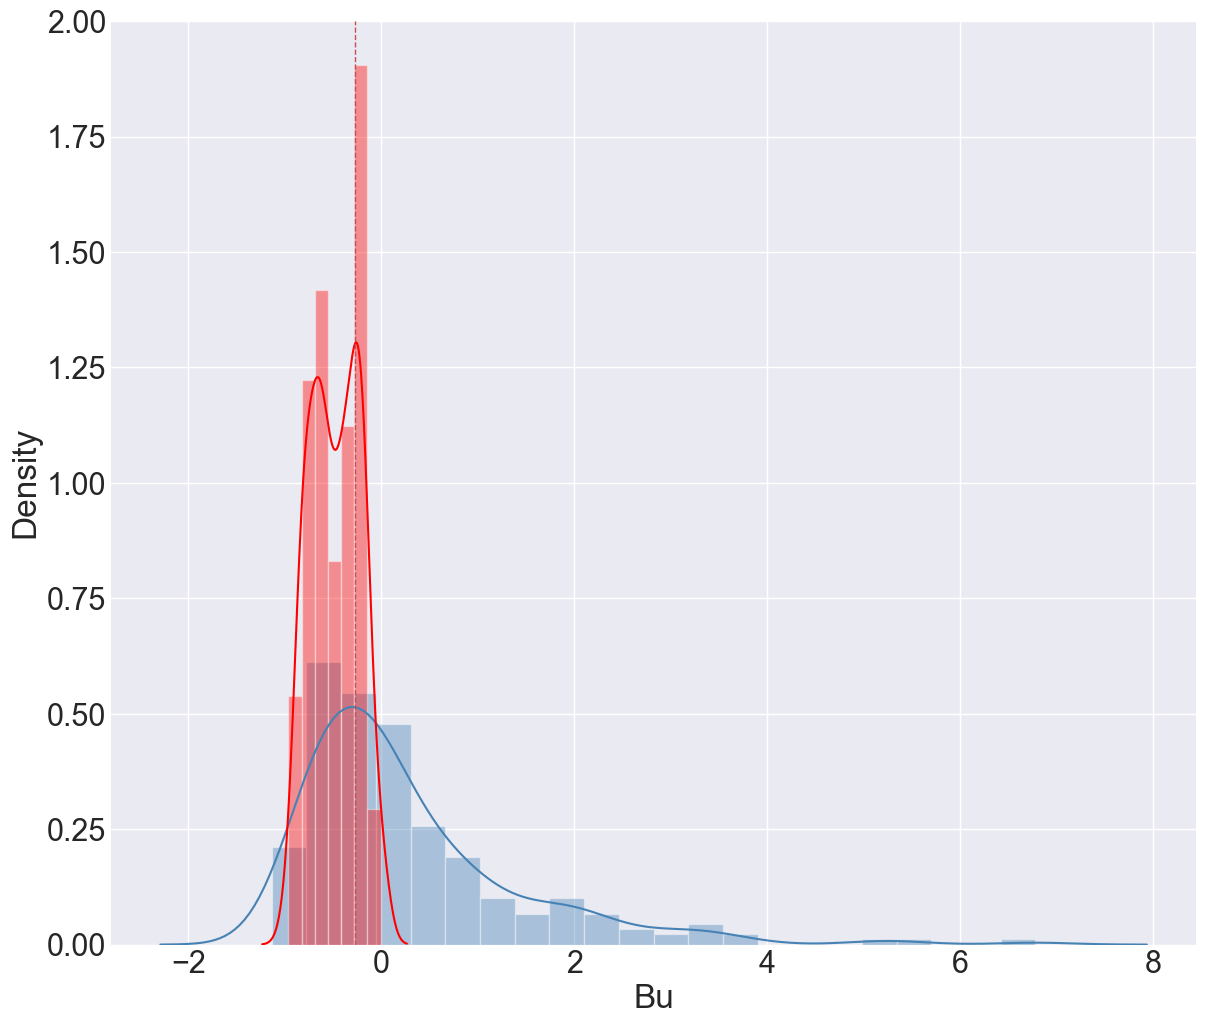

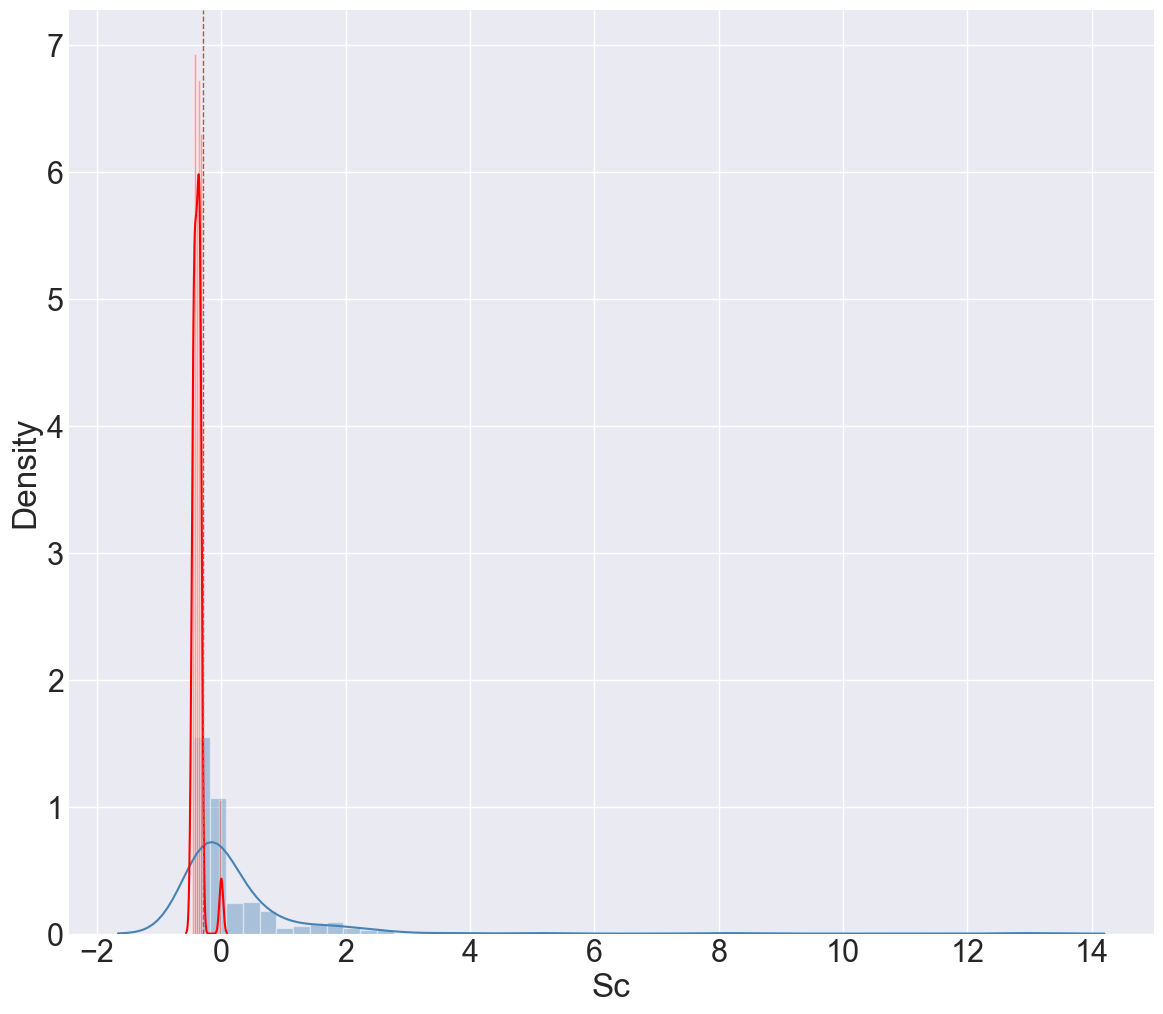

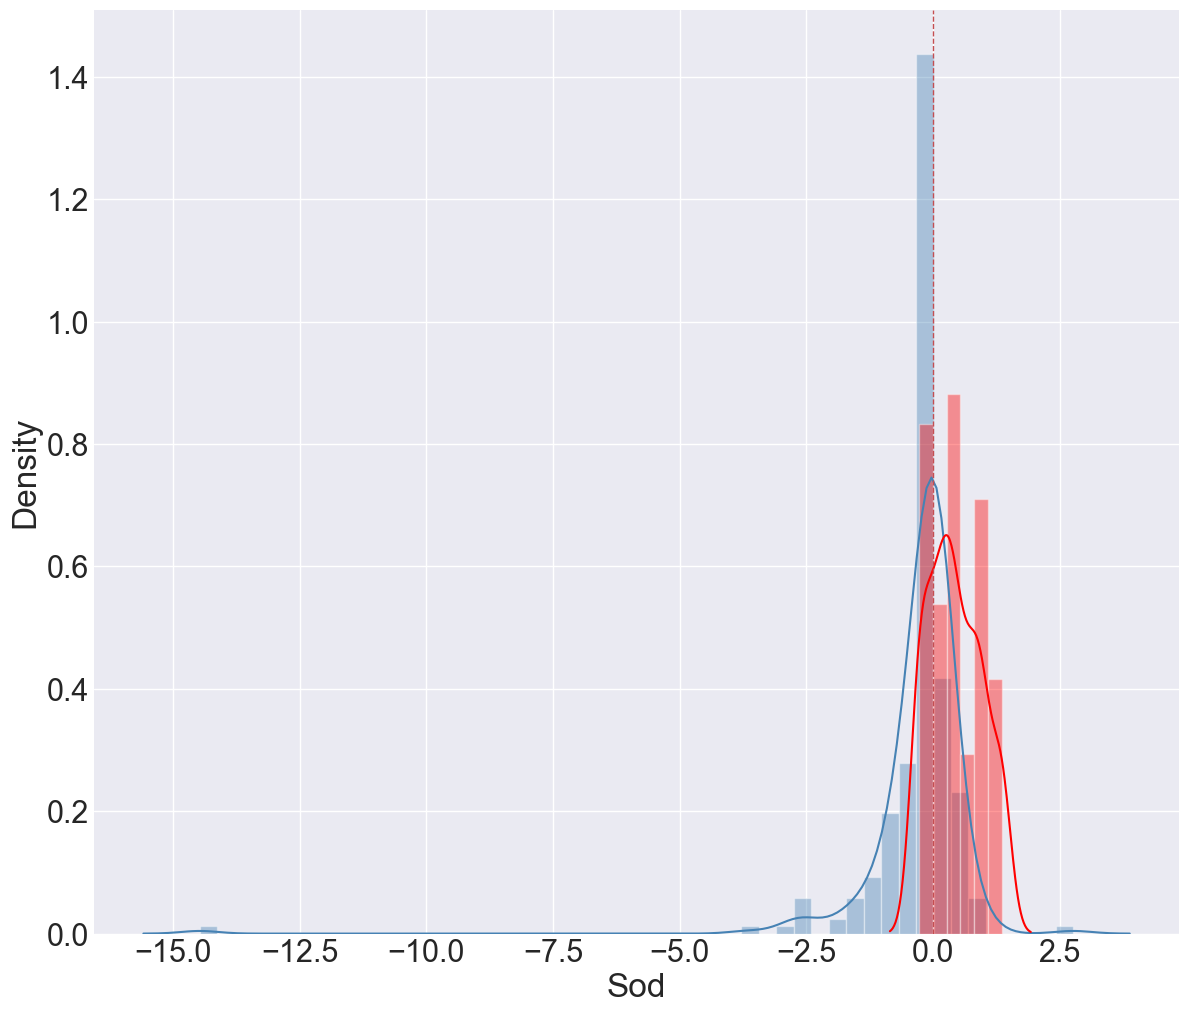

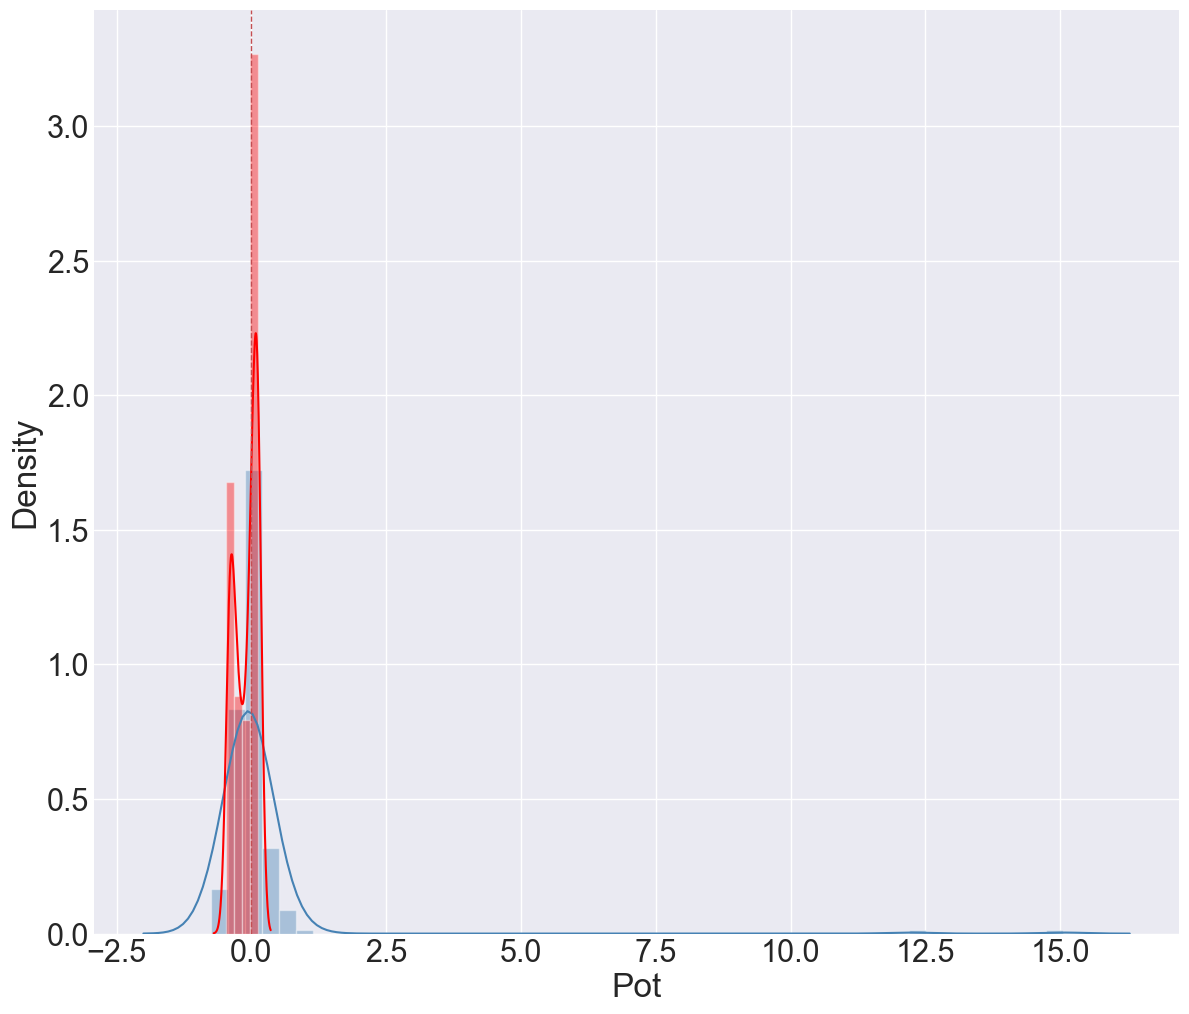

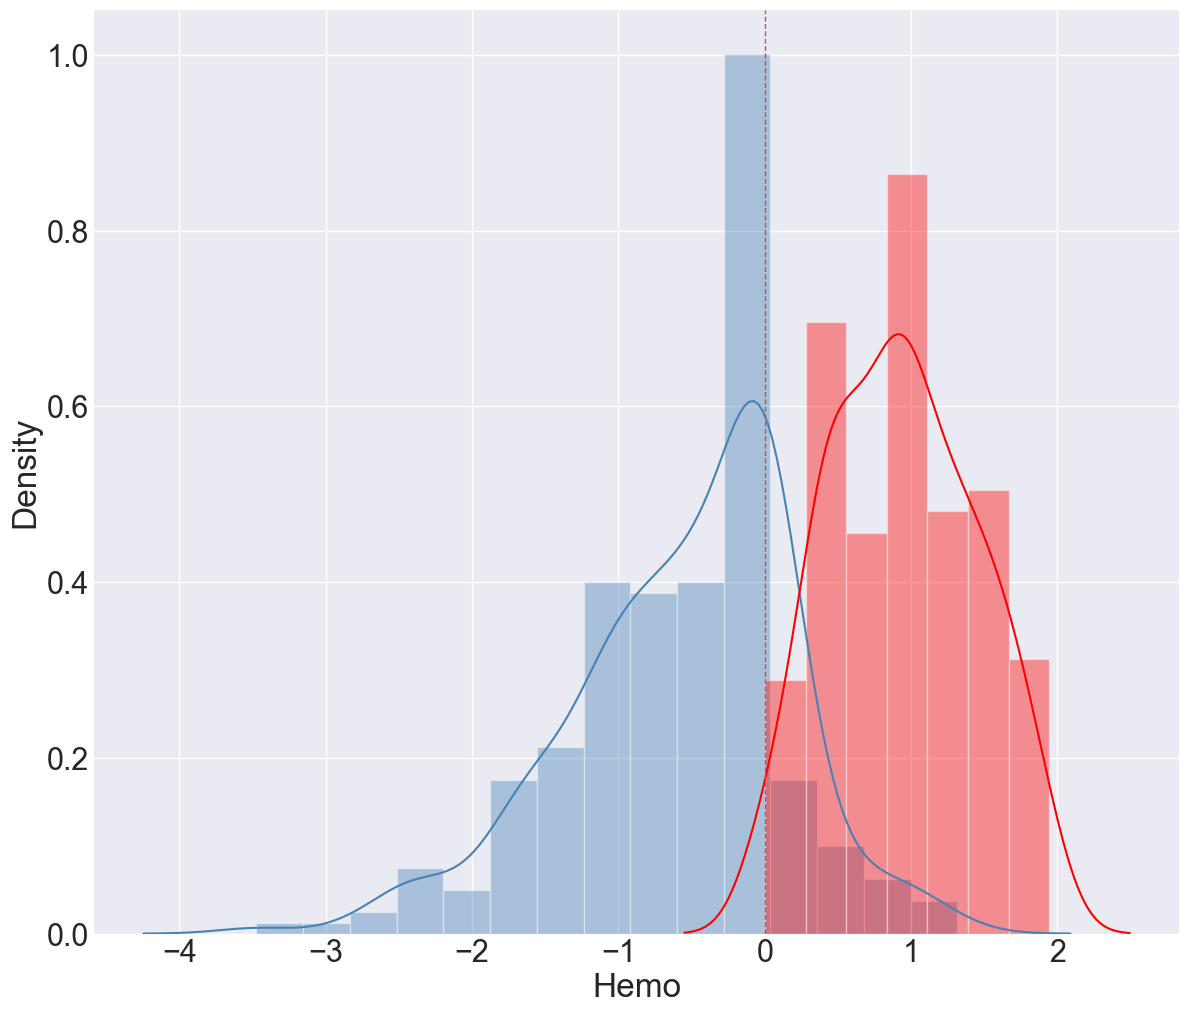

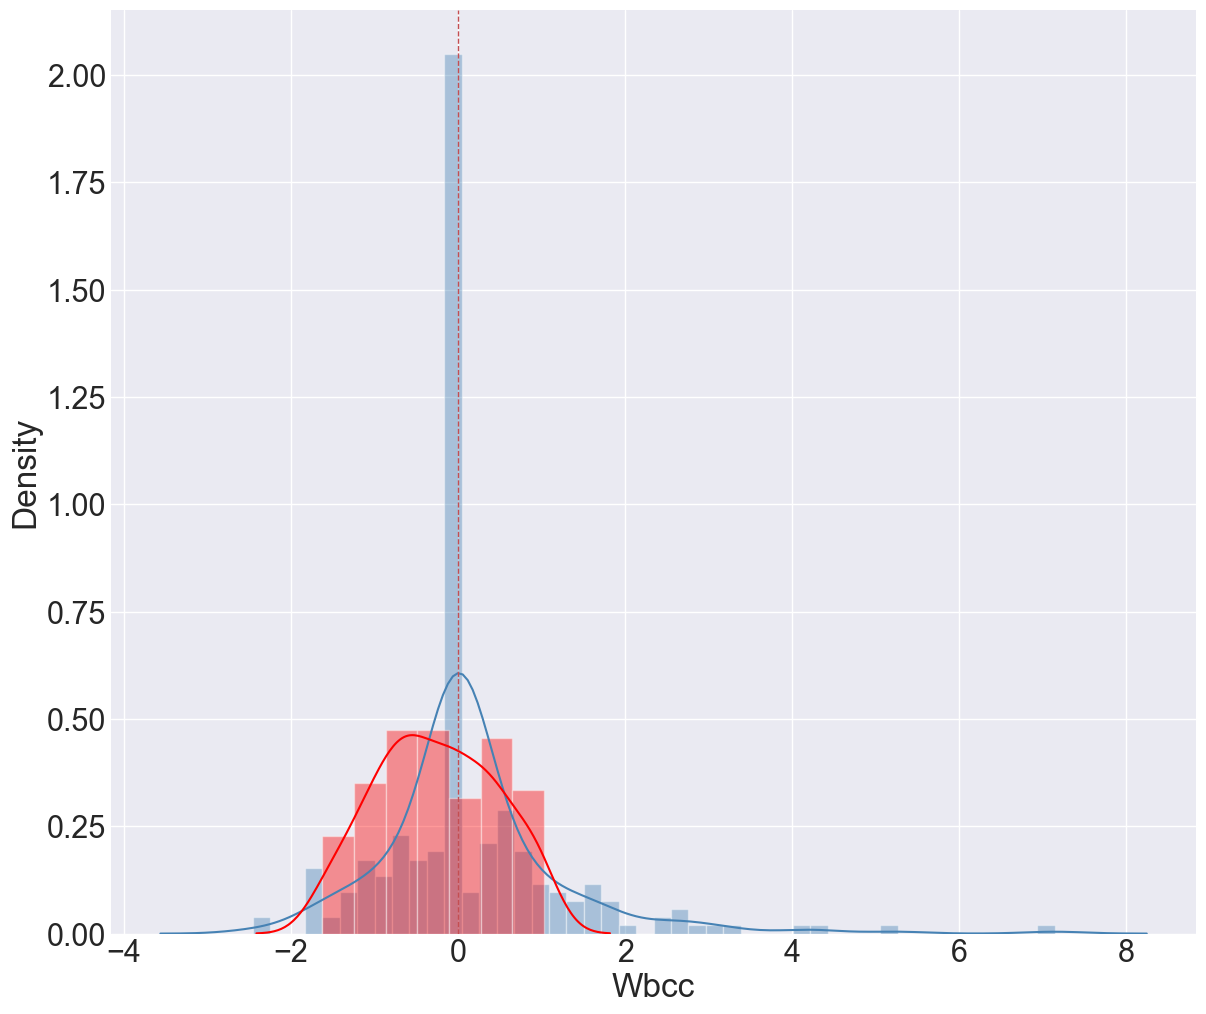

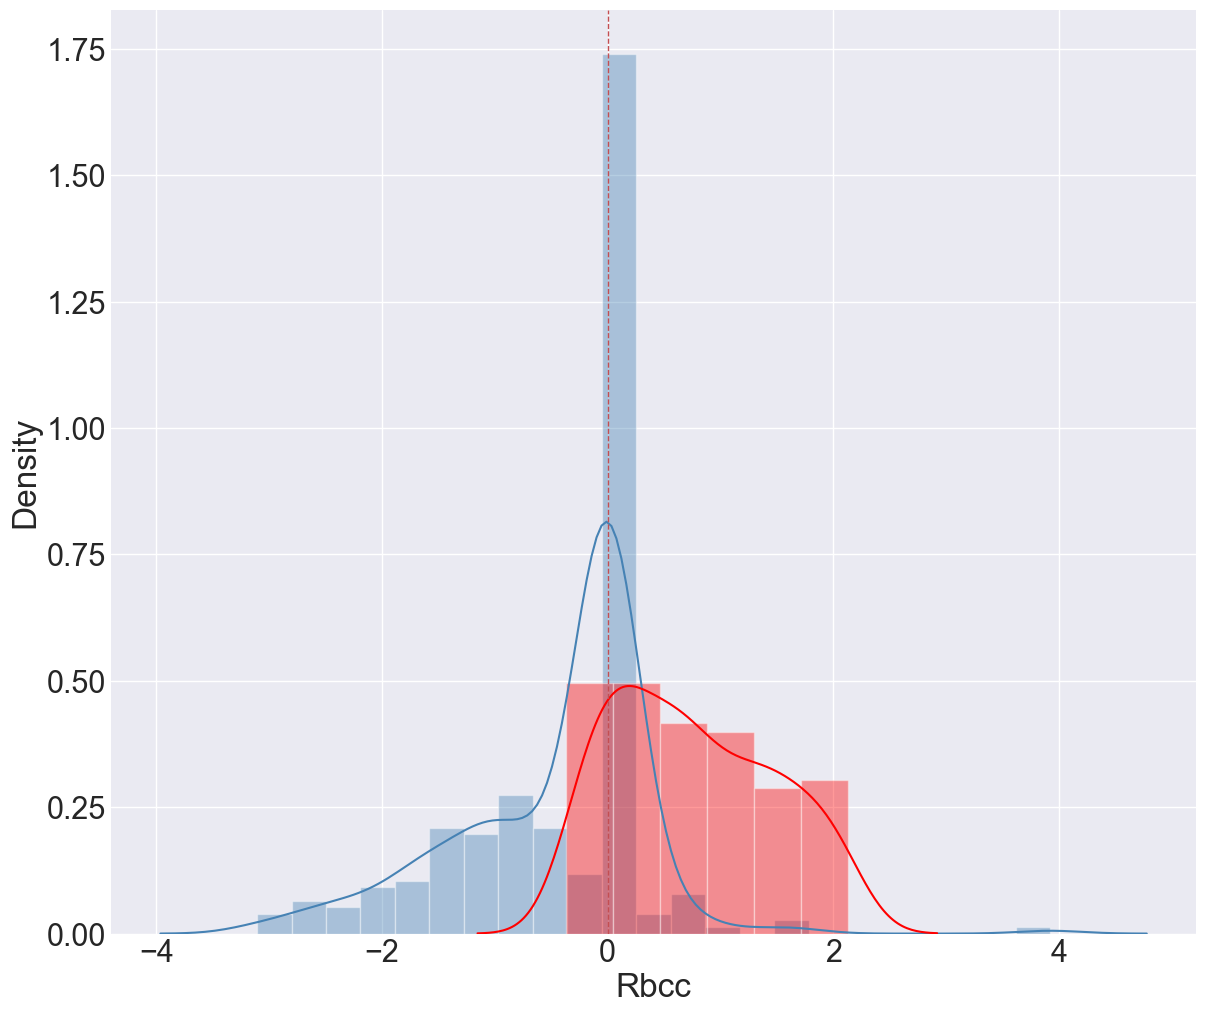

In [33]:
for colonne in variablesQuantitatives:
    afficheDistribution(donnees[colonne], donnees.Class)

# Transformation des modalités des variables qualitatives en colonnes

In [34]:
for nom in variablesQualitatives:
    createColumnsQualitatives(donnees,nom)

In [35]:
donnees.head()

,Bp,Sg,Bu,Sc,Sod,Pot,Hemo,Wbcc,Rbcc,Class,...,Su_0,Su_1,Su_2,Su_3,Su_4,Su_5,Rbc_0,Rbc_1,Htn_0,Htn_1
0,0.263379,0.421486,-0.434856,-0.333725,0.000106,0.000763,1.059100,-0.240506,0.585900,1,...,1,0,0,0,0,0,0,1,0,1
1,-1.965500,0.421486,-0.800529,-0.405020,0.000106,0.000763,-0.452268,-0.954773,0.002055,1,...,1,0,0,0,0,0,0,1,1,0
2,0.263379,-1.421074,-0.089498,-0.226782,0.000106,0.000763,-1.078932,-0.359550,0.002055,1,...,0,0,0,1,0,0,0,1,1,0
3,-0.479581,-2.342354,-0.028553,0.129695,-2.885860,-0.755560,-0.489130,-0.677003,-0.963076,1,...,1,0,0,0,0,0,0,1,0,1
4,0.263379,-1.421074,-0.638008,-0.298077,0.000106,0.000763,-0.341680,-0.438913,-0.129012,1,...,1,0,0,0,0,0,0,1,1,0


In [36]:
X = donnees.drop(columns='Class')
y = donnees.Class

In [37]:
X_train, X_test, y_train, y_test = train_test_split( X, 
                                                     y, 
                                                     test_size=0.2, 
                                                     random_state=seed, 
                                                     stratify = y
                                                   ) 

Decision Tree         0.9750	--	Area under the ROC curve : 0.9973	--	Exécution  :.03s
Random_Forest         0.9625	--	Area under the ROC curve : 0.9943	--	Exécution  :.11s
AdaBoost              0.9875	--	Area under the ROC curve : 0.9993	--	Exécution  :.08s
LogisticRegression    0.9875	--	Area under the ROC curve : 1.0000	--	Exécution  :.70s
Gaussian_Process      0.9875	--	Area under the ROC curve : 0.9947	--	Exécution  :.05s
Nearest_Neighbors     0.9875	--	Area under the ROC curve : 1.0000	--	Exécution  :.03s
Linear_SVMC           0.9875	--	Area under the ROC curve : 1.0000	--	Exécution  :.02s
NonLinaire_SVMC       1.0000	--	Area under the ROC curve : 1.0000	--	Exécution  :.05s
GaussianNaiveBayes    0.9125	--	Area under the ROC curve : 0.9987	--	Exécution  :.02s


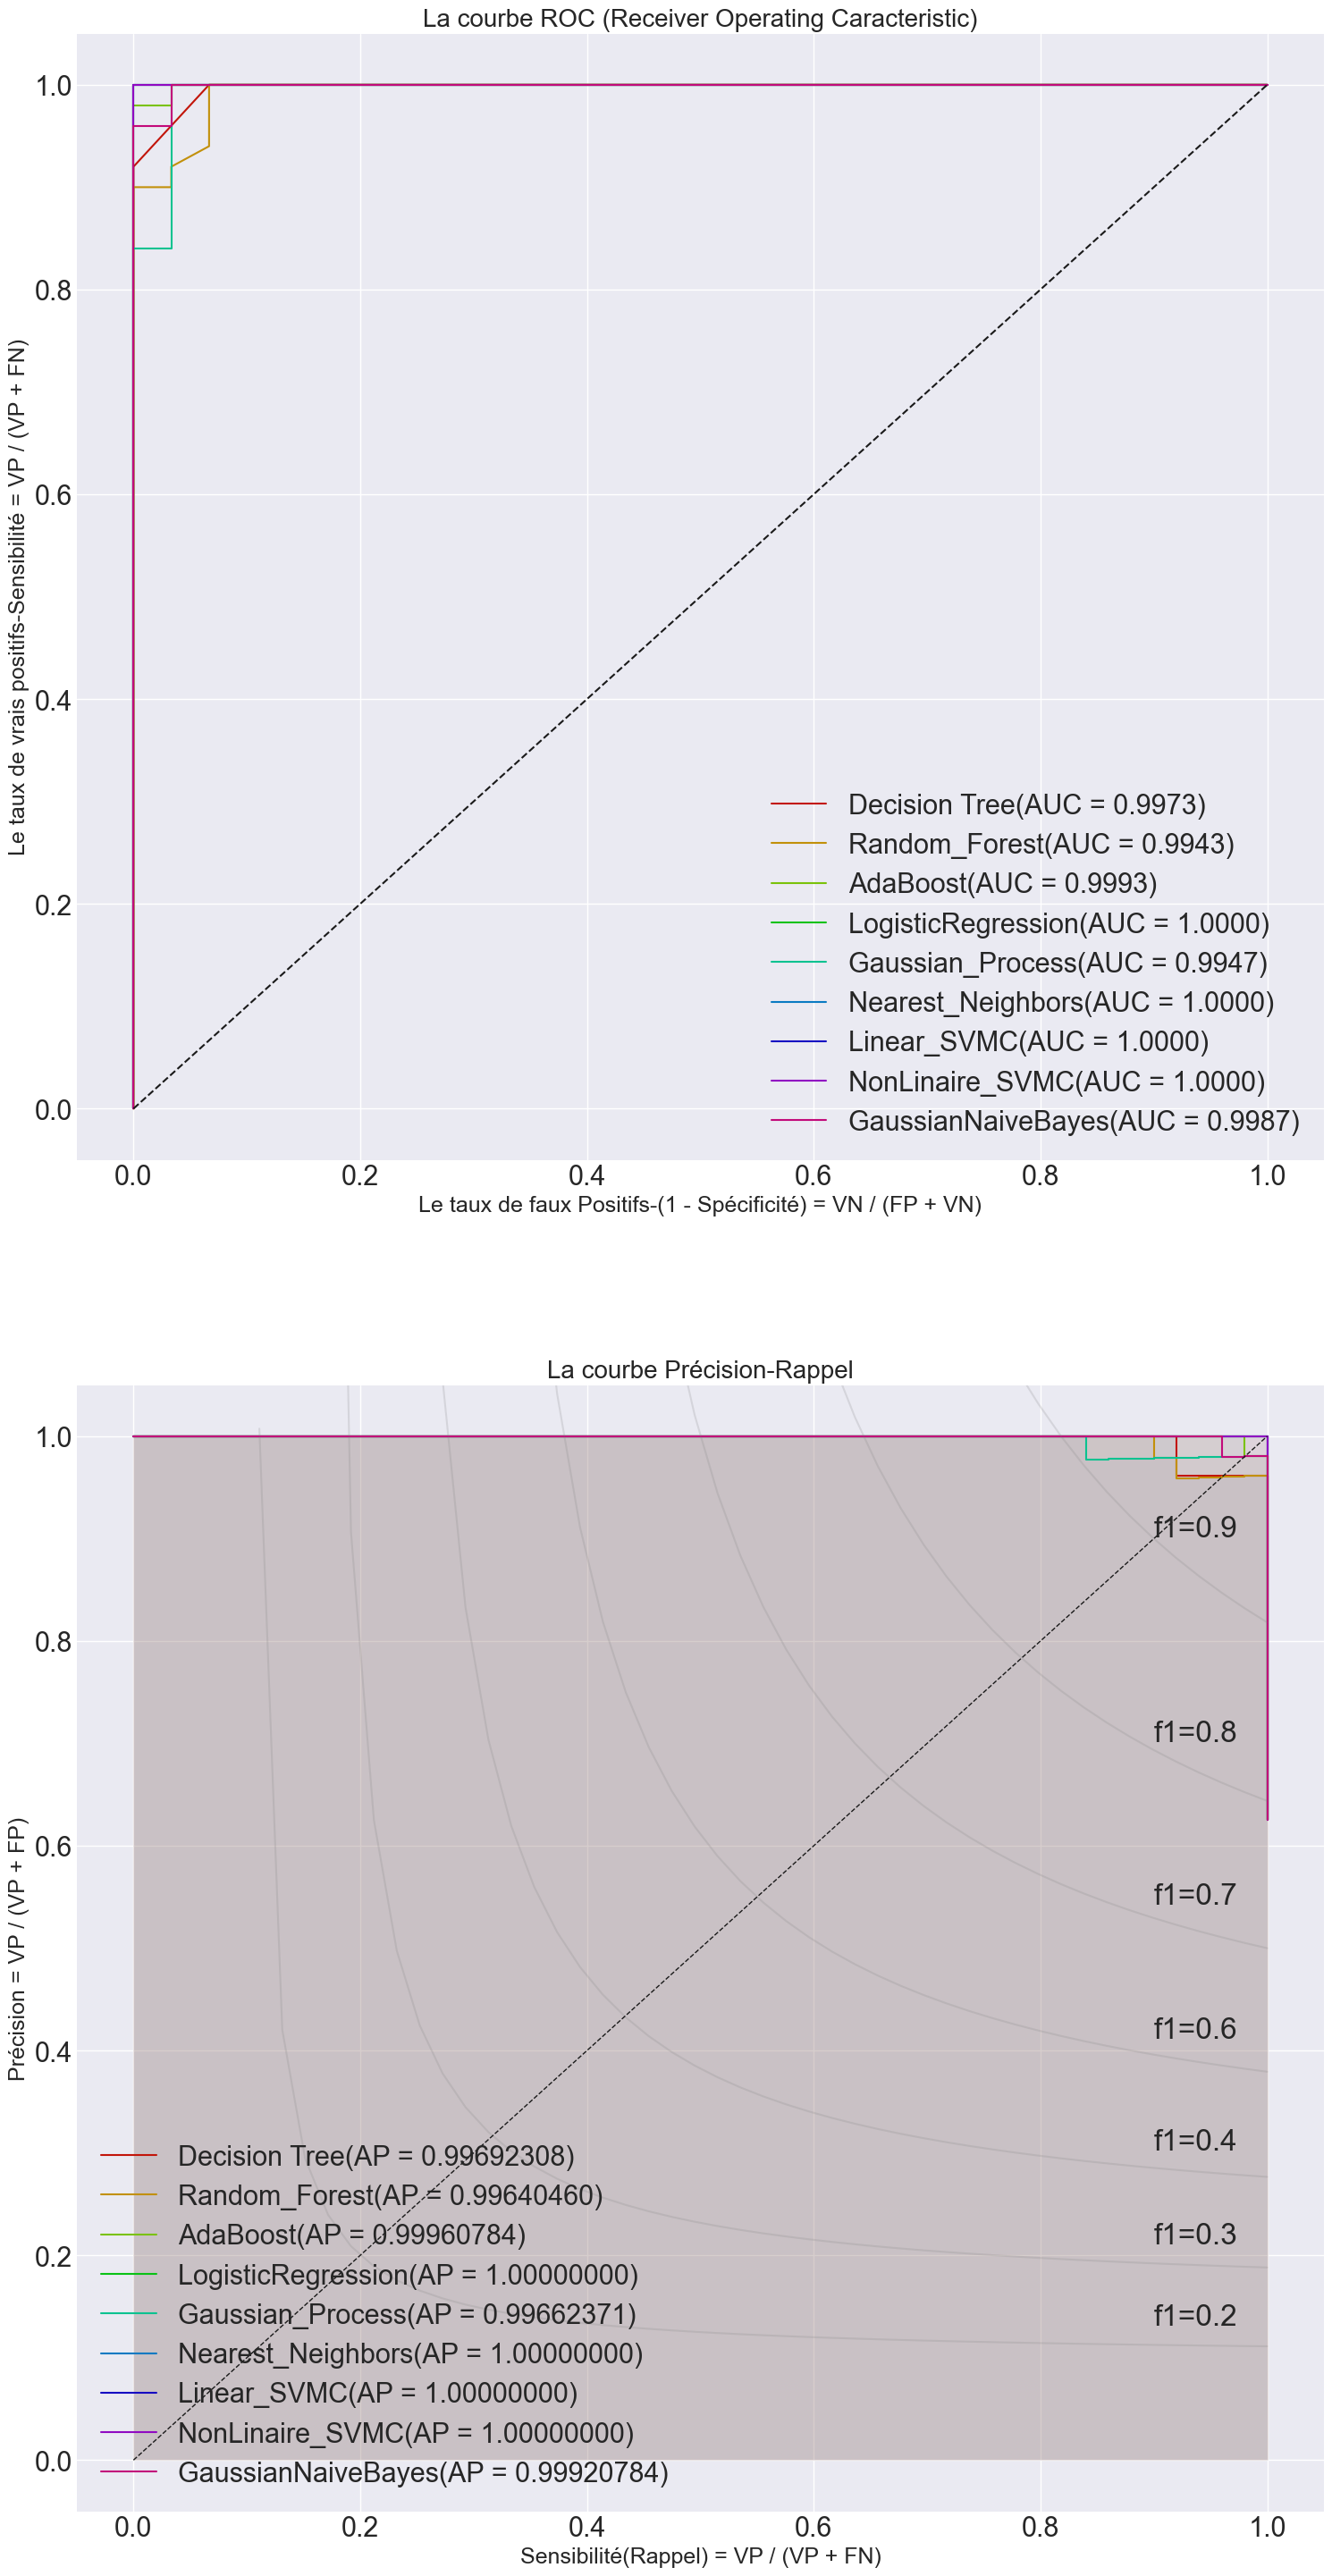

Exécution  :15.56s


In [38]:
resultats = executeChoixDesClassifieurs(dictModels, X_train, y_train, X_test, y_test, figsize=(18,36), lw = 1)

In [39]:
resultats.sort_values('accuracy',ascending=False)

,aucROC,avgPrecRec,accuracy,f1,precision,sensibilite,logloss,hammingloss,jaccard
NonLinaire_SVMC,1.000000,1.000000,1.0000,1.000000,1.000000,1.00,2.220446e-16,0.0000,1.000000
AdaBoost,0.999333,0.999608,0.9875,0.989899,1.000000,0.98,4.505457e-01,0.0125,0.980000
LogisticRegression,1.000000,1.000000,0.9875,0.990099,0.980392,1.00,4.505457e-01,0.0125,0.980392
Gaussian_Process,0.994667,0.996624,0.9875,0.990099,0.980392,1.00,4.505457e-01,0.0125,0.980392
Nearest_Neighbors,1.000000,1.000000,0.9875,0.989899,1.000000,0.98,4.505457e-01,0.0125,0.980000
Linear_SVMC,1.000000,1.000000,0.9875,0.990099,0.980392,1.00,4.505457e-01,0.0125,0.980392
Decision Tree,0.997333,0.996923,0.9750,0.980392,0.961538,1.00,9.010913e-01,0.0250,0.961538
Random_Forest,0.994333,0.996405,0.9625,0.970297,0.960784,0.98,1.351637e+00,0.0375,0.942308
GaussianNaiveBayes,0.998667,0.999208,0.9125,0.924731,1.000000,0.86,3.153820e+00,0.0875,0.860000


In [40]:
resultats['nom']='SS+Qualites'

In [41]:
resultats_etude = pd.concat([resultats_etude,resultats])

In [42]:
resultats_etude.sort_values('accuracy',ascending=False)

,aucROC,avgPrecRec,accuracy,f1,precision,sensibilite,logloss,hammingloss,jaccard,nom
NonLinaire_SVMC,1.000000,1.000000,1.0000,1.000000,1.000000,1.00,2.220446e-16,0.0000,1.000000,SS+Qualites
Random_Forest,1.000000,1.000000,0.9875,0.990099,0.980392,1.00,4.505457e-01,0.0125,0.980392,initial
AdaBoost,0.999333,0.999608,0.9875,0.989899,1.000000,0.98,4.505457e-01,0.0125,0.980000,initial
Linear_SVMC,1.000000,1.000000,0.9875,0.990099,0.980392,1.00,4.505457e-01,0.0125,0.980392,SS+Qualites
Nearest_Neighbors,1.000000,1.000000,0.9875,0.989899,1.000000,0.98,4.505457e-01,0.0125,0.980000,SS+Qualites
Gaussian_Process,0.994667,0.996624,0.9875,0.990099,0.980392,1.00,4.505457e-01,0.0125,0.980392,SS+Qualites
LogisticRegression,1.000000,1.000000,0.9875,0.990099,0.980392,1.00,4.505457e-01,0.0125,0.980392,SS+Qualites
AdaBoost,0.999333,0.999608,0.9875,0.989899,1.000000,0.98,4.505457e-01,0.0125,0.980000,SS+Qualites
Decision Tree,0.997333,0.996923,0.9750,0.980392,0.961538,1.00,9.010913e-01,0.0250,0.961538,initial
Decision Tree,0.997333,0.996923,0.9750,0.980392,0.961538,1.00,9.010913e-01,0.0250,0.961538,SS+Qualites
